In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from collections import defaultdict
import os
import re

In [2]:
authors_short_dict = {"MWS": "Mary Shelley", "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}
df = pd.DataFrame(pd.read_json("preprocessing_output/preprocessed_test_W.json").author)
df["author_short"] = df.author
df.author = df.author.apply(lambda x: authors_short_dict[x])
for filename in os.listdir("results_output/"):
    fileparts = filename.split("_")
    method = fileparts[1]
    if "template" in method:
        continue
    preprocessing = ".".join(fileparts[2].split(".")[:-1])
    df[f"{method} with {preprocessing}"] = pd.read_json(f"results_output/results_{method}_{preprocessing}.json")
# df

metrics = [("Accuracy", accuracy_score), ("Precision", lambda x, y: precision_score(x, y, average="macro")), ("Recall",
                                                                                                              lambda x, y: recall_score(x, y, average="macro")), ("F1 Score", lambda x, y: f1_score(x, y, average="macro"))]

In [3]:
total_table = pd.DataFrame()
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        authors = defaultdict(lambda: [])
        for author in ["EAP", "HPL", "MWS"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
            author_df = pd.DataFrame({"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1) 
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            authors[author] = author_df.iloc[:, 2:].apply(lambda x: func(author_df["author_short"], x))
        authors = pd.DataFrame(authors)
        total_table = pd.concat([total_table, authors], axis=1)
pd.set_option('display.max_columns', None)
total_table.columns = pd.MultiIndex.from_product([map(lambda x: x[0], metrics), ["bayes", "lda"], ["EAP", "HPL", "MWS"]])
total_table

Accuracy                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.872829  0.913943  0.896578  0.762513  0.797753  0.813585   
CSPH1e-4  0.711951  0.768641  0.756384  0.668284  0.714760  0.693565   
WSP       0.876915  0.914198  0.905516  0.789581  0.807457  0.830439   
CSPH1e-5  0.746425  0.803371  0.780644  0.689479  0.734678  0.722421   
C         0.724974  0.783963  0.766343  0.626915  0.667518  0.719867   
WSPH1e-4  0.853933  0.668539  0.654750  0.694076  0.731103  0.735189   
WSPH1e-6  0.876915  0.914198  0.905516  0.786772  0.805669  0.818693   
CSPH5e-5  0.722676  0.781920  0.775281  0.687947  0.717058  0.718080   
CSPH1e-6  0.750511  0.808733  0.780388  0.651430  0.731869  0.739275   
WSPH5e-4  0.636619  0.767365  0.756895  0.612104  0.672625  0.656537   
CSPH5e-4  0.629724  0.717314  0.699949  0.633044  0.606486  0.622063   
CSP       0.750511  0.808733  0.780388  0.657814  0.729571  0.740296   
WSPH1e-5  0.853422  0.894791  0.890705  0.770174  0.781154  0.817926   
WSPH5e-5  0.806180  0.862870  0.861593  0.710163  0.747446  0.762513   
WL        0.872829  0.913943  0.896578  0.767875  0.791879  0.821757   
WPH1e-4   0.766854  0.836057  0.830695       NaN       NaN       NaN   

         Precision                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.866795  0.900087  0.877484  0.753398  0.767926  0.852162   
CSPH1e-4  0.702084  0.719575  0.716444  0.650358  0.655776  0.650475   
WSP       0.869472  0.904697  0.890387  0.780373  0.772689  0.817863   
CSPH1e-5  0.734682  0.763010  0.745306  0.677063  0.685152  0.672365   
C         0.713205  0.738852  0.728337  0.633538  0.635978  0.755836   
WSPH1e-4  0.857707  0.585982  0.626786  0.678790  0.682770  0.695001   
WSPH1e-6  0.869472  0.904697  0.890387  0.777750  0.769473  0.797845   
CSPH5e-5  0.711830  0.736419  0.738943  0.671624  0.669049  0.672912   
CSPH1e-6  0.738769  0.770000  0.745463  0.663822  0.680068  0.722706   
WSPH5e-4  0.681102  0.740516  0.723988  0.592985  0.603977  0.603132   
CSPH5e-4  0.634578  0.645720  0.644975  0.608054  0.573778  0.581088   
CSP       0.738769  0.770000  0.745463  0.667937  0.680750  0.731283   
WSPH1e-5  0.845480  0.881756  0.876134  0.759348  0.746155  0.812136   
WSPH5e-5  0.800401  0.846475  0.844871  0.698355  0.705228  0.725079   
WL        0.866795  0.900087  0.877484  0.758207  0.761661  0.857793   
WPH1e-4   0.765193  0.814249  0.809952       NaN       NaN       NaN   

            Recall                                                    \
             bayes                           lda                       
               EAP       HPL       MWS       EAP       HPL       MWS   
W         0.866961  0.889737  0.885079  0.761430  0.811993  0.715153   
CSPH1e-4  0.708490  0.704557  0.711083  0.644917  0.656491  0.658247   
WSP       0.876453  0.884537  0.890041  0.776284  0.809112  0.773651   
CSPH1e-5  0.736368  0.755490  0.747552  0.680654  0.697214  0.650959   
C         0.716969  0.733320  0.723866  0.639345  0.659495  0.563291   
WSPH1e-4  0.834141  0.577708  0.643021  0.664952  0.697250  0.702057   
WSPH1e-6  0.876453  0.884537  0.890041  0.772153  0.802468  0.766201   
CSPH5e-5  0.717226  0.725983  0.733252  0.660915  0.684764  0.673671   
CSPH1e-6  0.738606  0.760048  0.752895  0.669773  0.688567  0.618562   
WSPH5e-4  0.674440  0.646257  0.673195  0.592442  0.603656  0.604516   
CSPH5e-4  0.640643  0.615759  0.633042  0.574244  0.586646  0.588471   
CSP       0.738606  0.760048  0.752895  0.674588  0.694630  0.615768   
WSPH1e-5  0.855595  0.858780  0.867531  0.760384  0.781302  0.747066   
WSPH5e-5  0.813101  0.811626  0.827528  0.678339  0.728273  0.730807   
WL        0.866961  0.889737  0.885079  0.765288

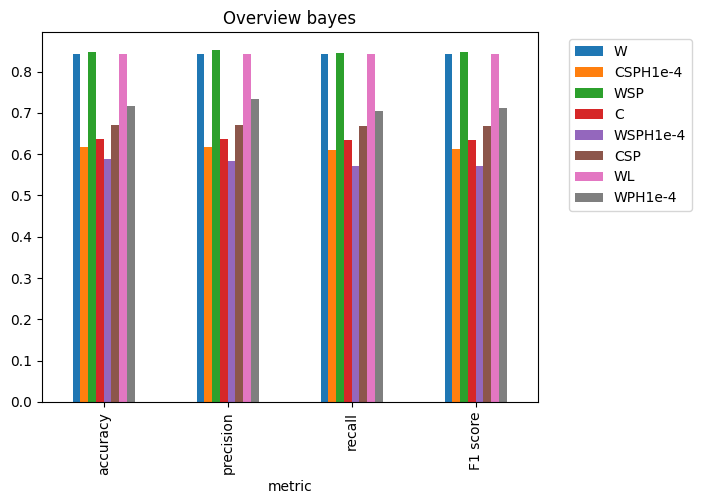

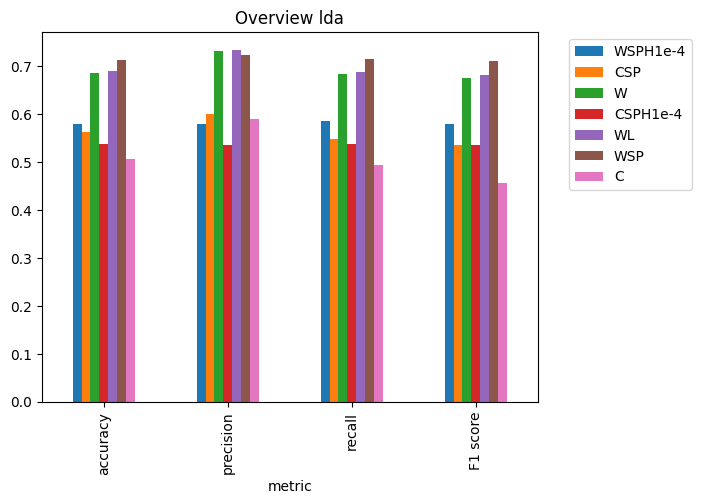

In [4]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
    method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
    score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
    score_df["metric"] = ["accuracy", "precision", "recall", "F1 score"]
    score_df.plot.bar("metric", title=f"Overview {method}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

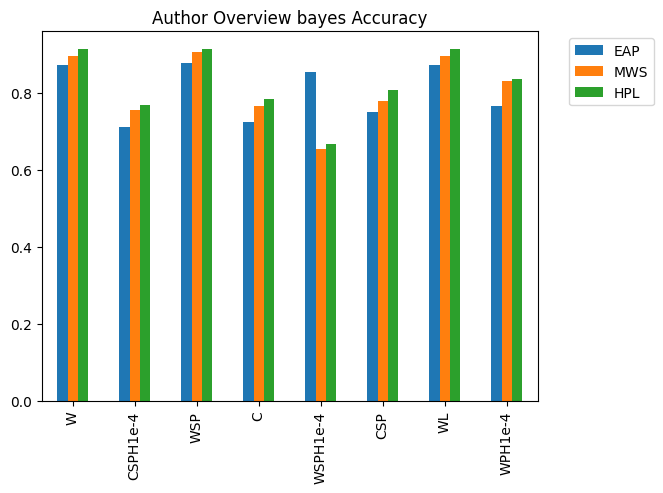

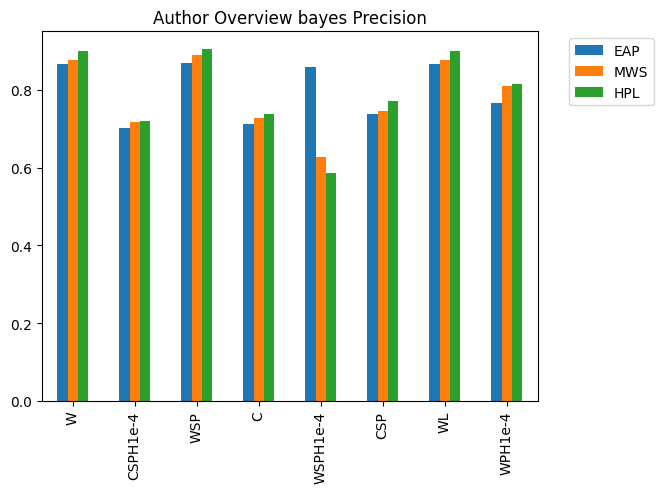

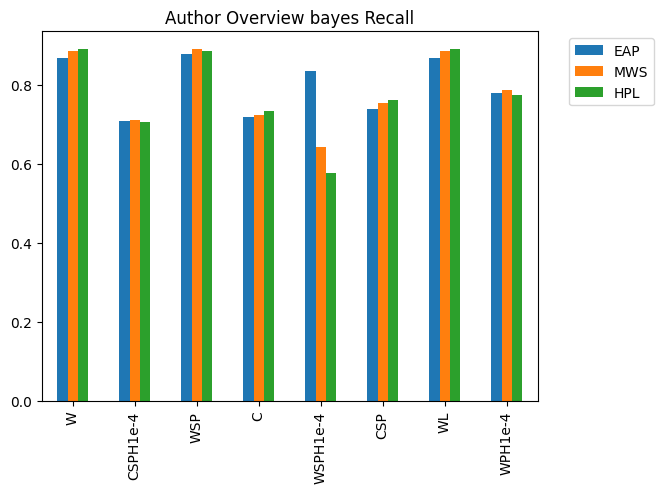

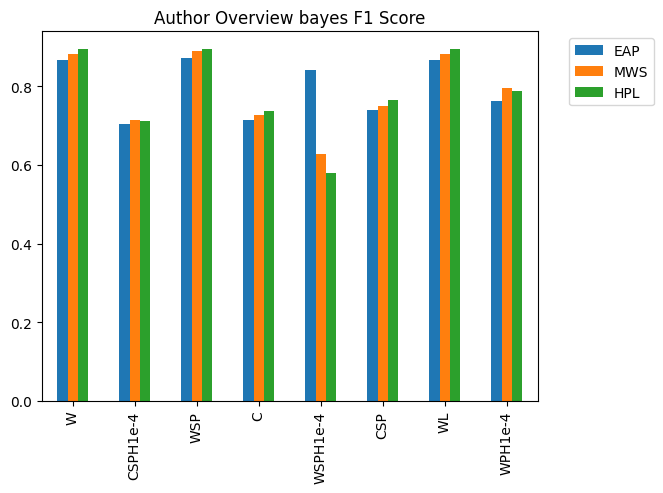

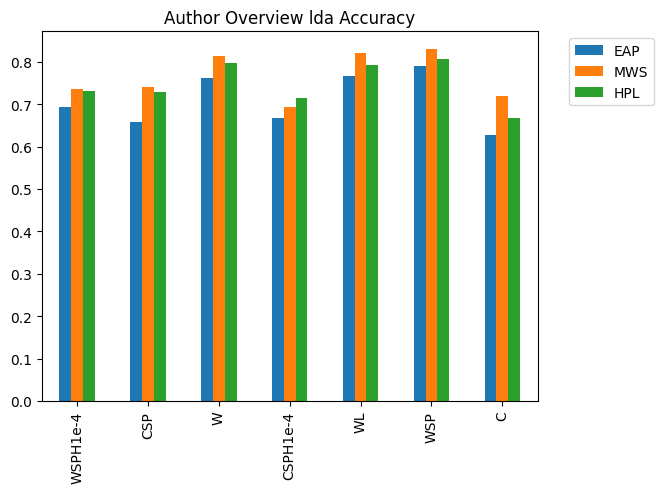

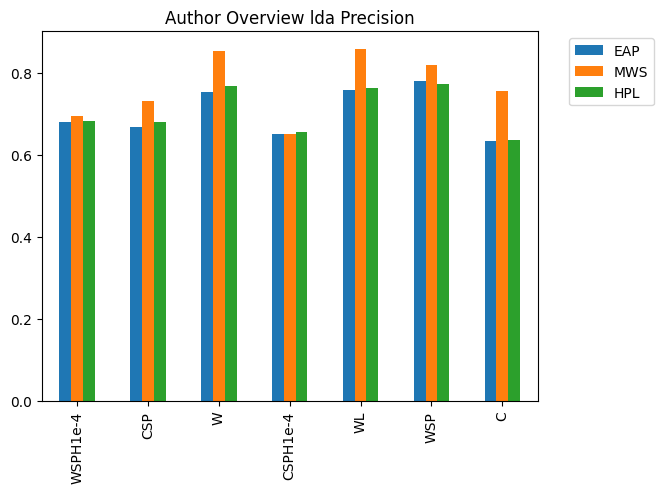

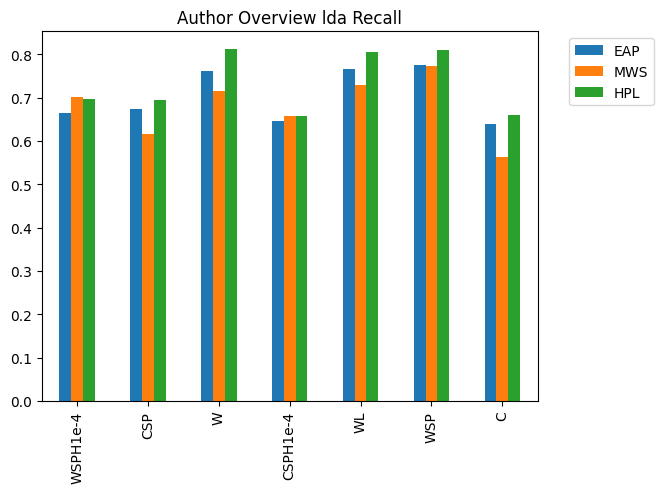

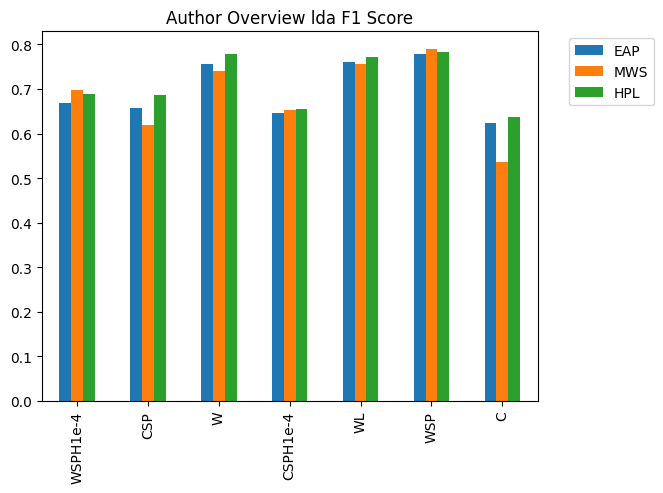

In [5]:
for method in ["bayes", "lda"]:
    for (name, func) in metrics:
        score_df = {}
        method_df = df.loc[:, df.columns.str.contains(
            f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = author_df.iloc[:, 2:].apply(
                lambda x: func(author_df["author_short"], x))
        score_df = pd.DataFrame(score_df)
        score_df.plot.bar(title=f"Author Overview {method} {name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


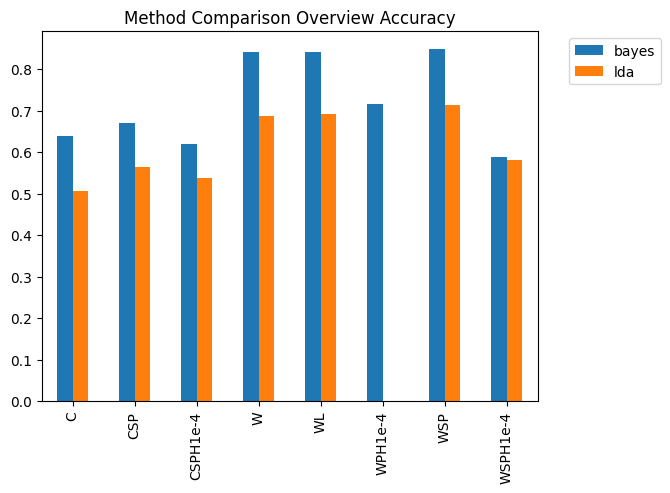

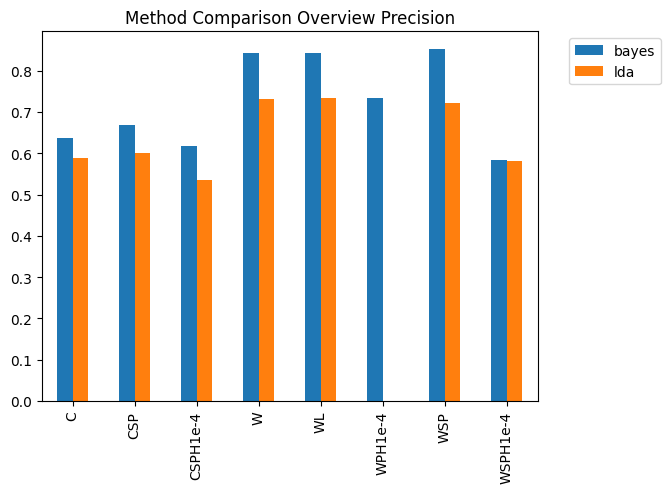

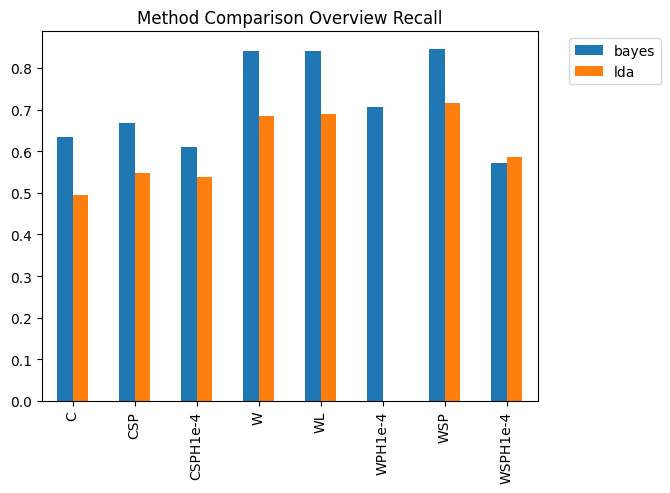

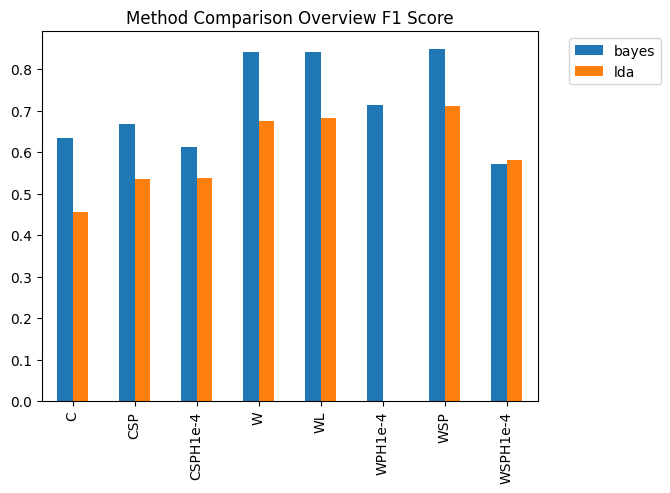

In [6]:
for (name, func) in metrics:
    preprocess_df = {}
    for method in ["bayes", "lda"]:
        score_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        score_df = score_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = score_df.iloc[:, 2:].apply(lambda x: func(score_df["author_short"], x))
        preprocess_df[method] = score_df
    preprocess_df = pd.DataFrame(preprocess_df)
    preprocess_df.plot.bar(title=f"Method Comparison Overview {name}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_420/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_420/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_420/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
/tmp/ipykernel_420/299294681.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


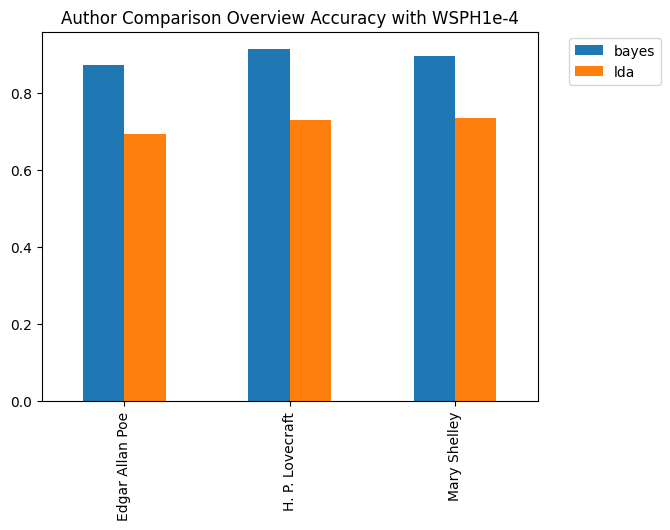

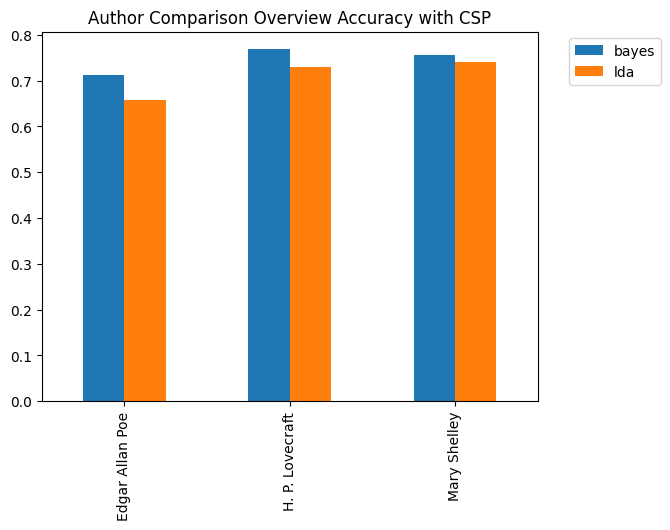

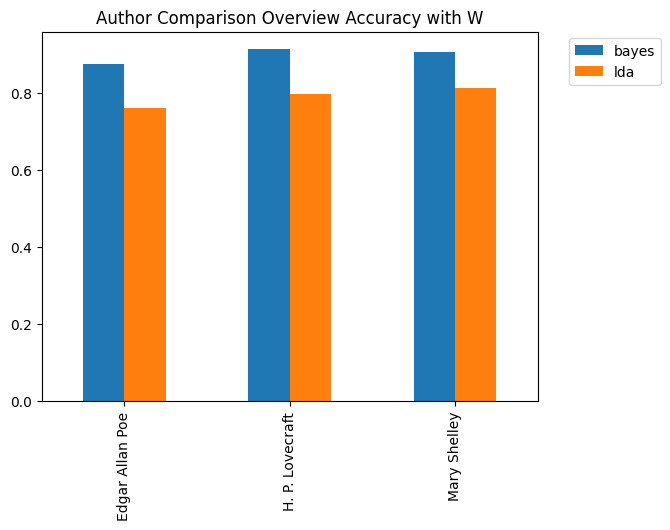

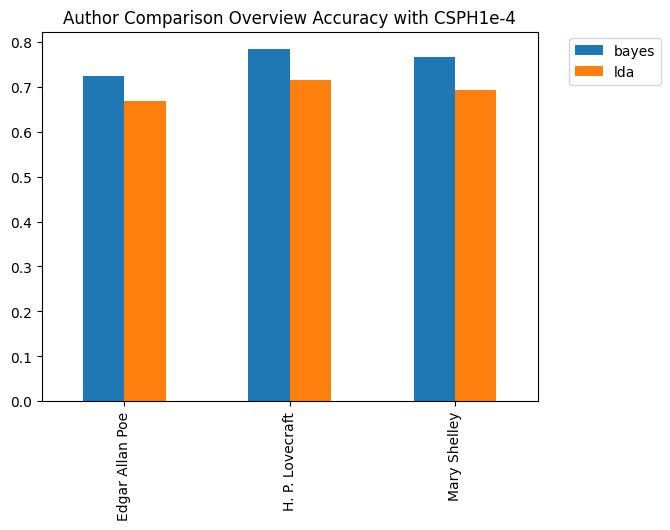

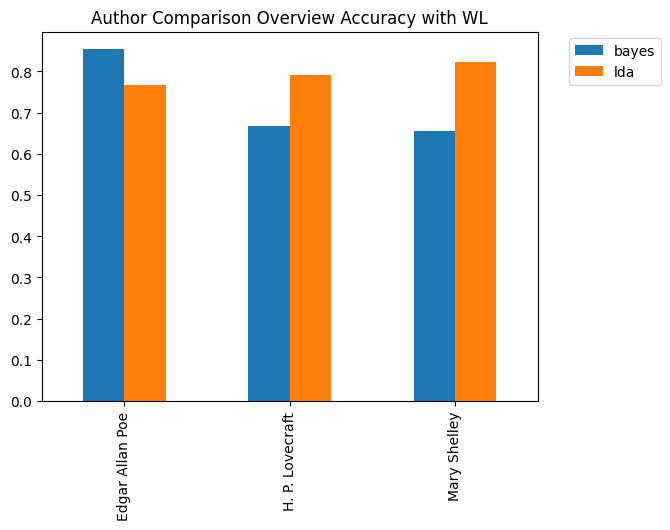

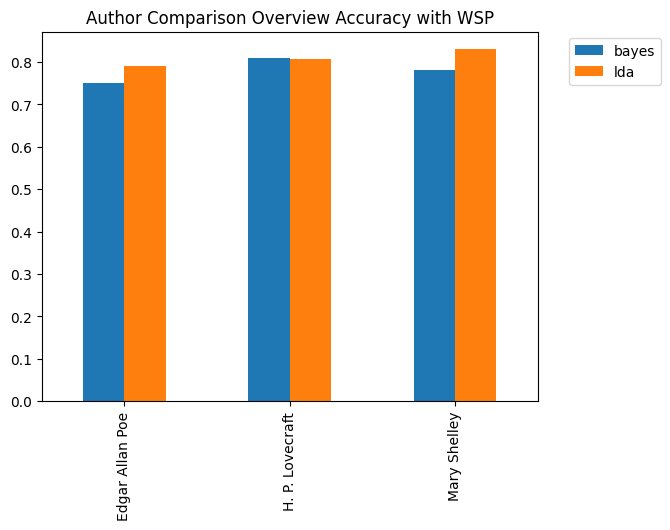

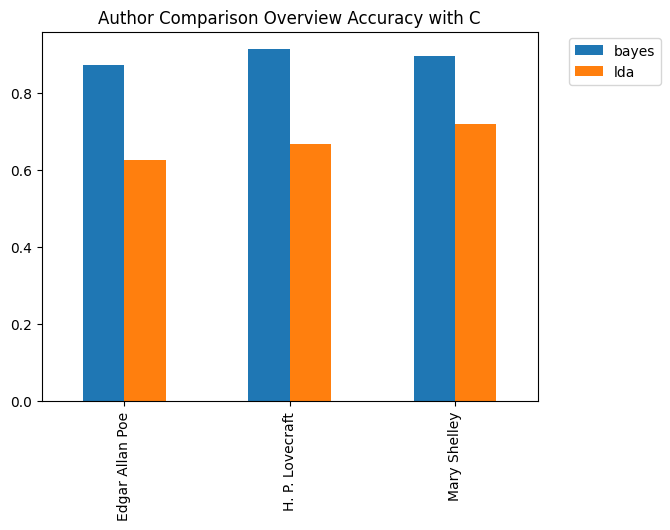

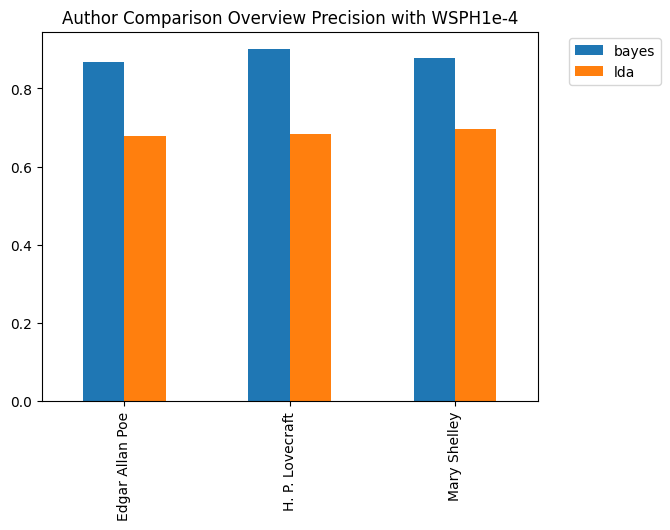

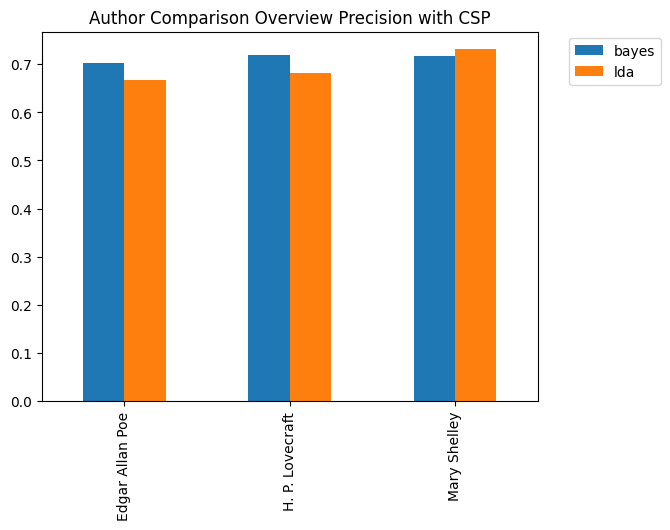

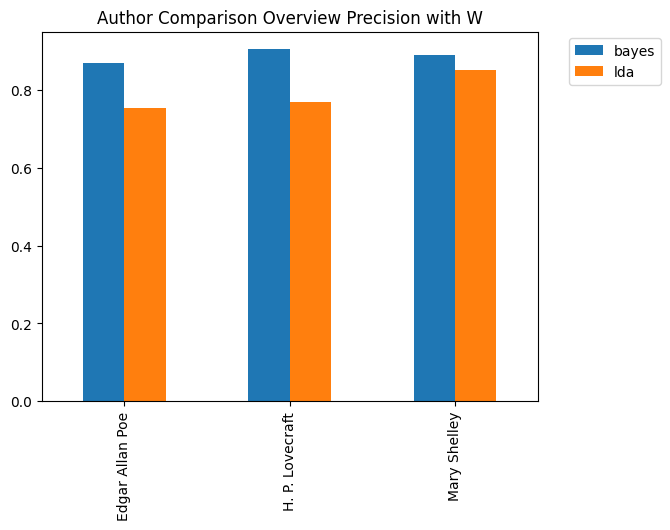

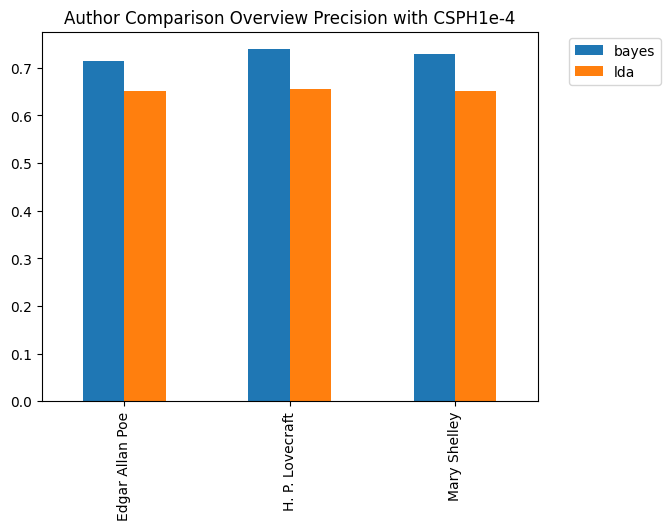

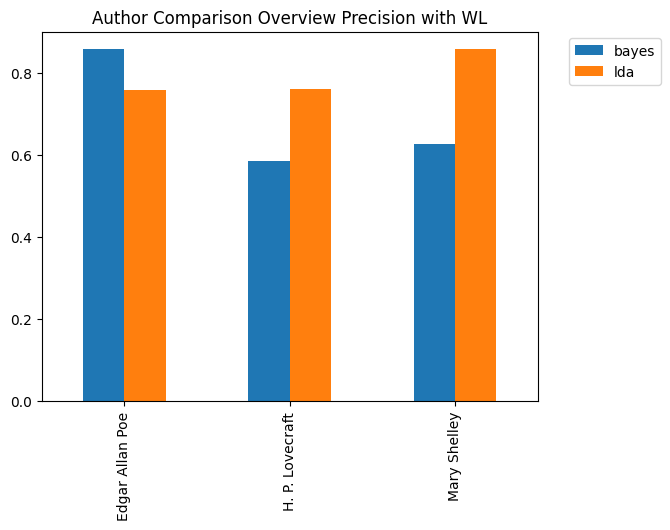

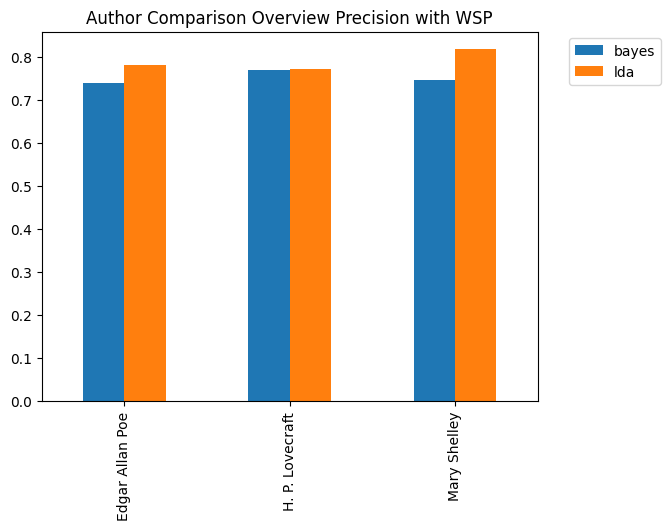

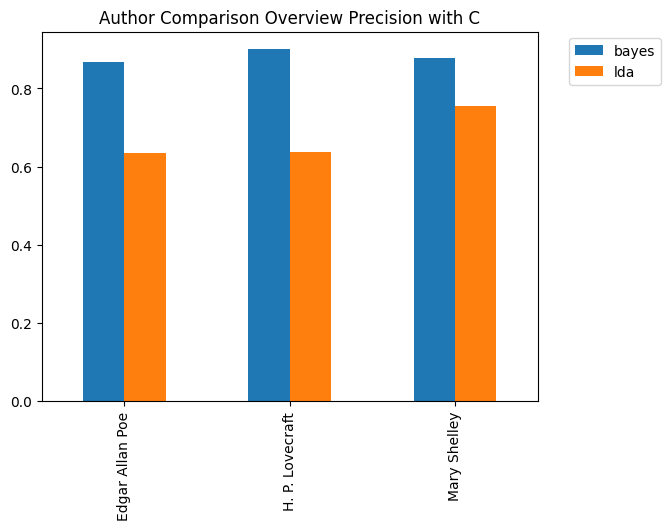

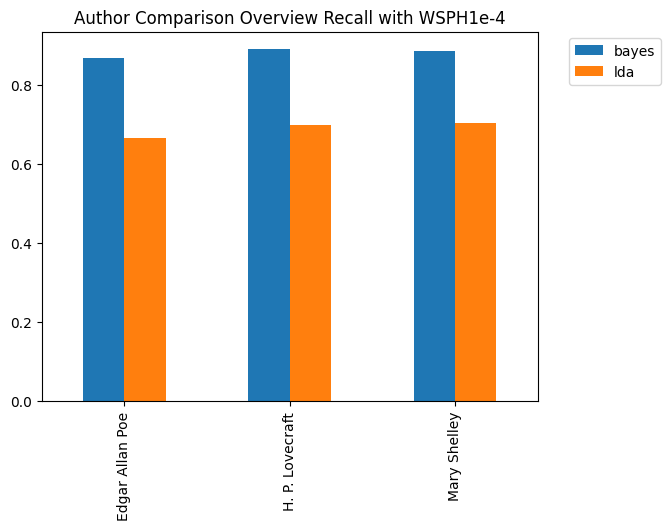

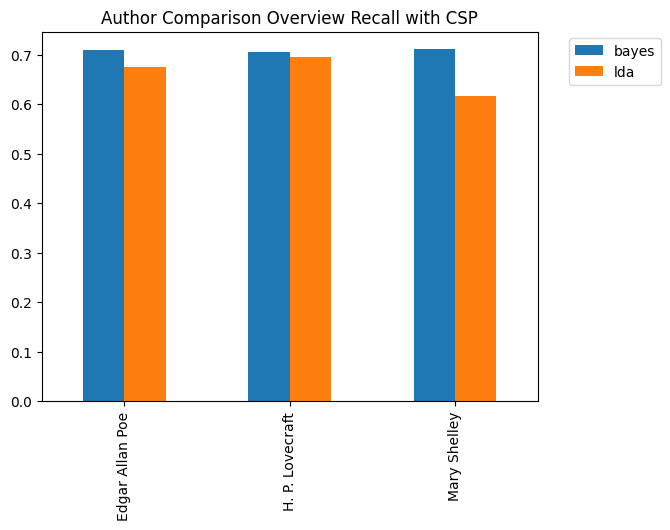

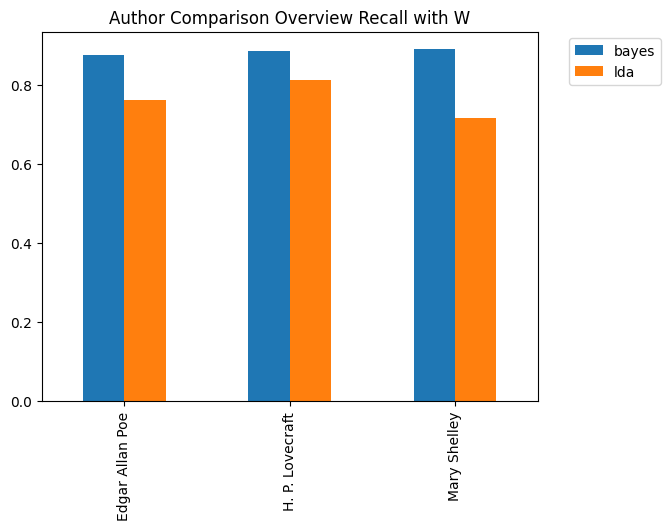

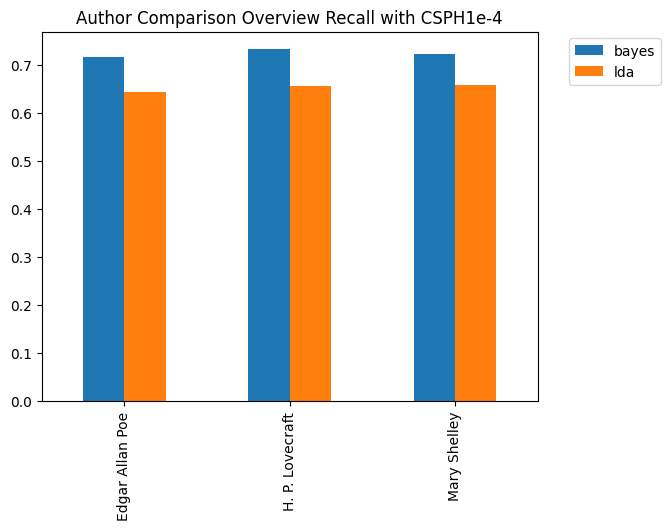

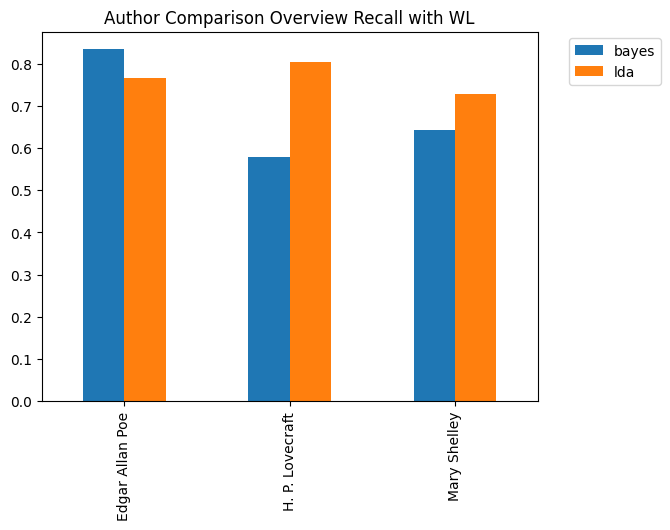

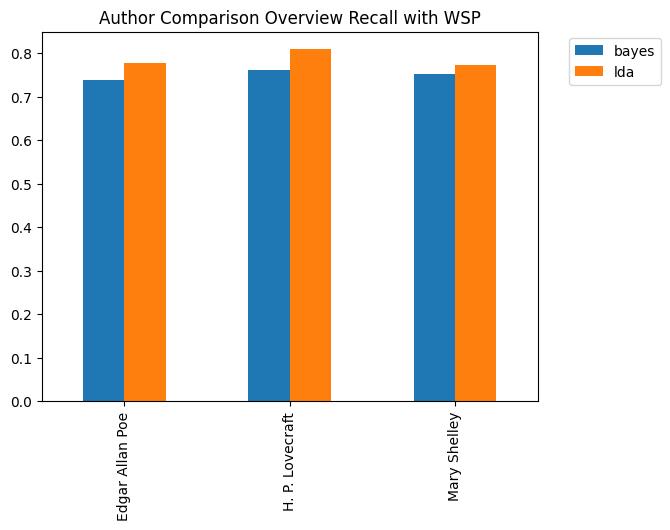

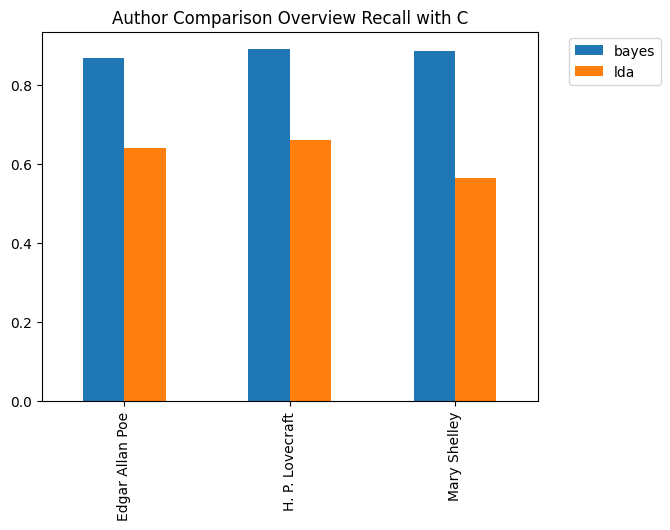

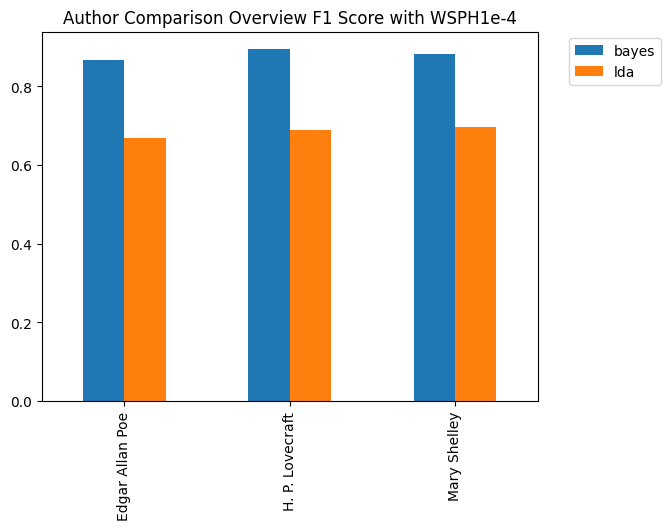

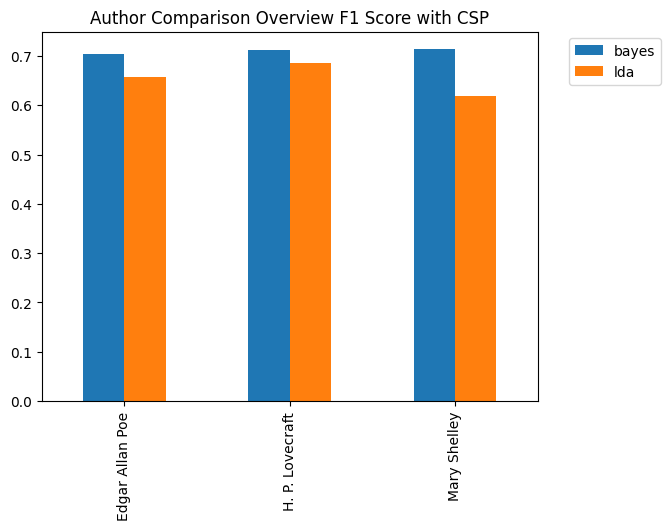

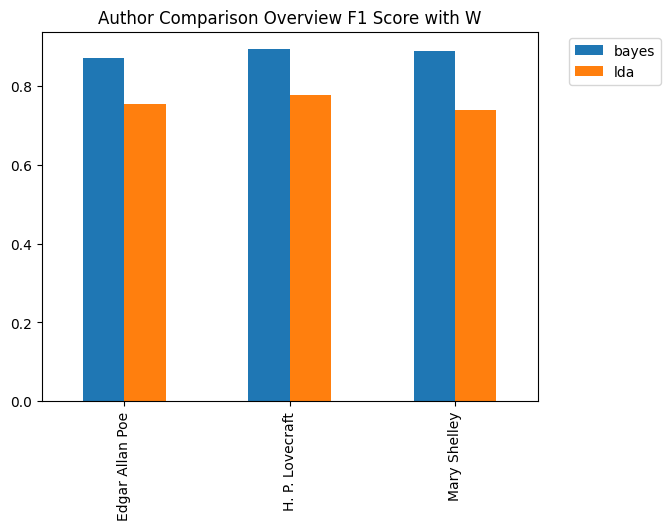

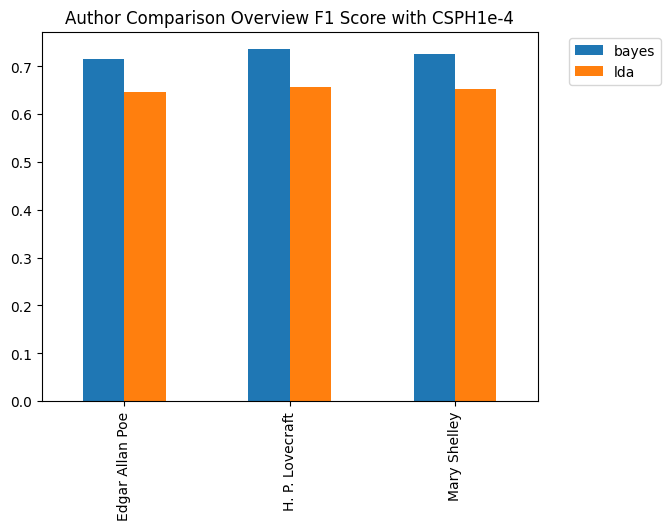

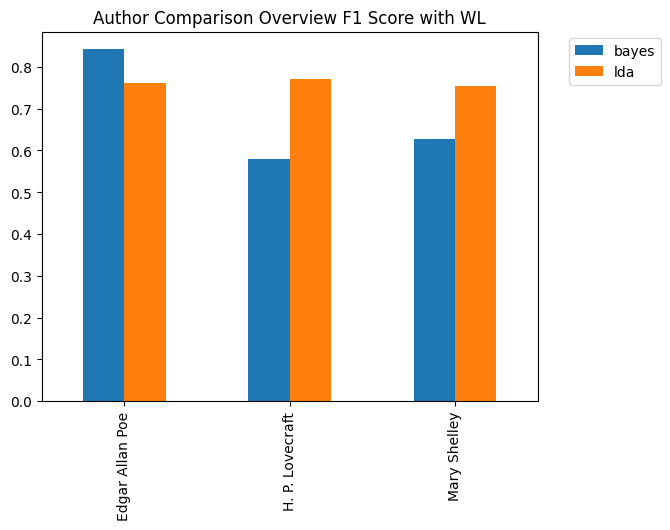

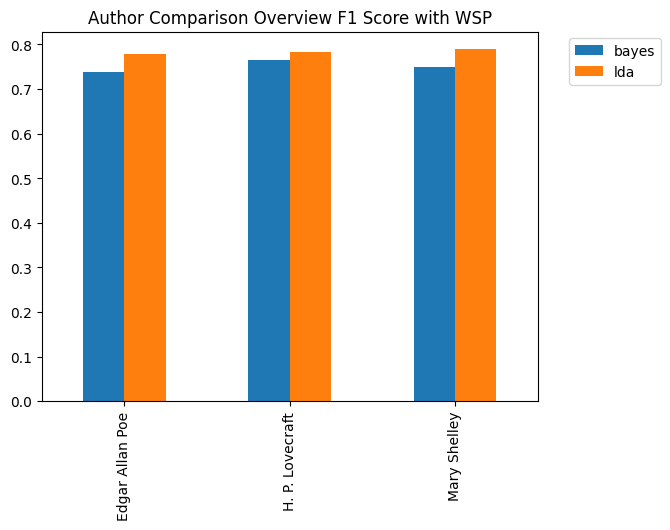

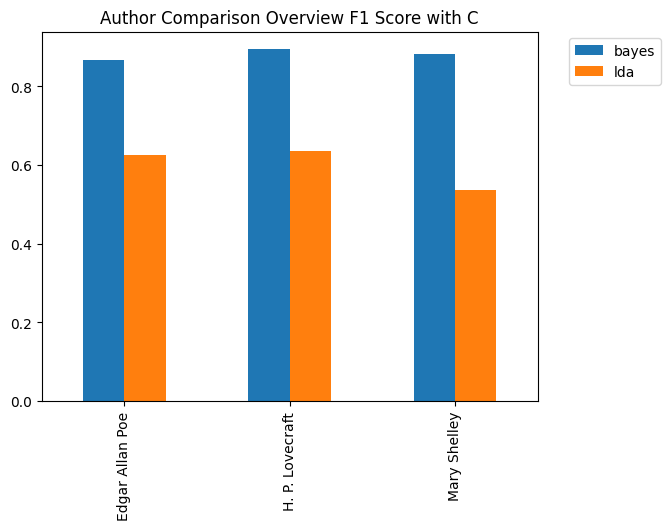

In [7]:
for (name, func) in metrics:
    method_df = df.loc[:, df.columns.str.contains(f"^[^56]*$")]
    for preprocessing in range(2,int((len(method_df.columns)) / 2 + 1)):
        authors = defaultdict(lambda: [])
        preprocess_name = ""
        for author in ["EAP", "HPL", "MWS"]:
            author_df = pd.DataFrame(
                            {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            for method in ["bayes", "lda"]:
                process_df = author_df.loc[:, author_df.columns.str.contains(f"(.*{method}.*)|(.*author.*)", regex=True)]
                preprocess_name = re.sub(".*\s(\S+)$", r"\1", process_df.columns[preprocessing])
                authors[author].append(func(process_df["author_short"],process_df.iloc[:, preprocessing]))
        authors = pd.DataFrame(authors)
        authors = authors.rename(columns=lambda x: authors_short_dict[x])
        authors["method"] = ["bayes", "lda"]
        authors = authors.pivot_table(columns ="method")
        authors.plot.bar(title=f"Author Comparison Overview {name} with {preprocess_name}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

/tmp/ipykernel_420/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/tmp/ipykernel_420/579560021.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
/home/tristan/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


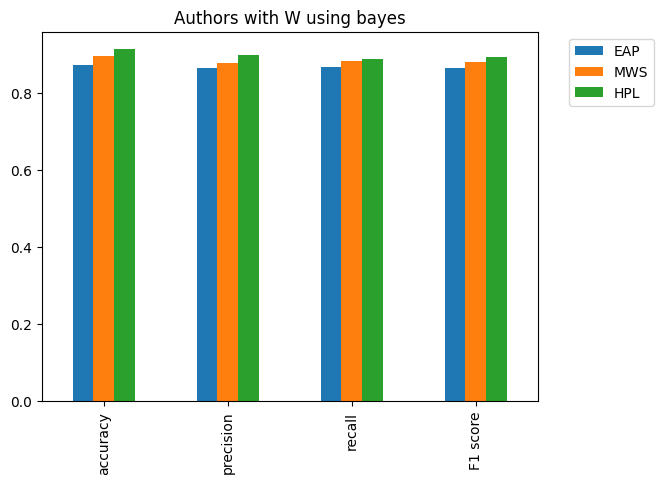

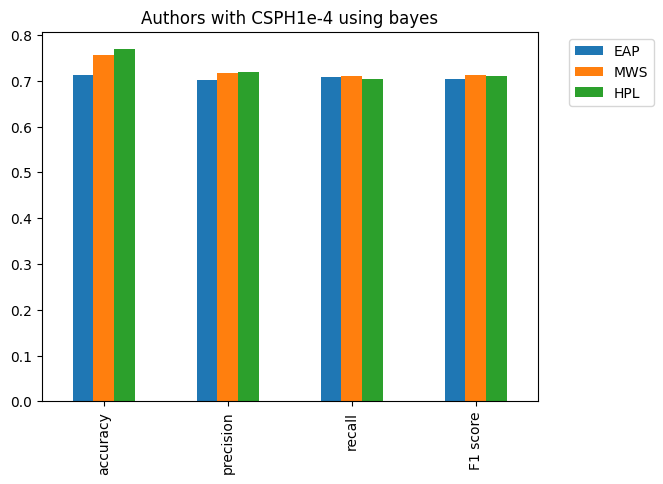

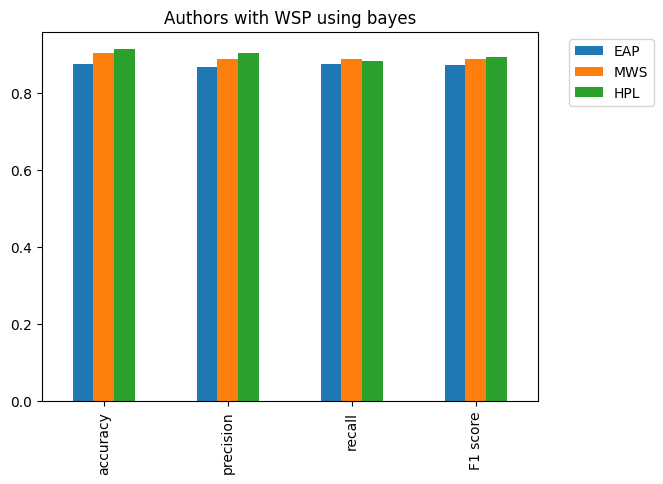

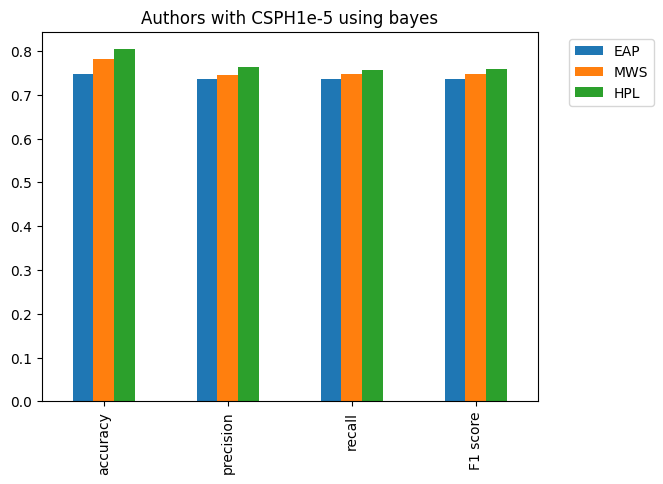

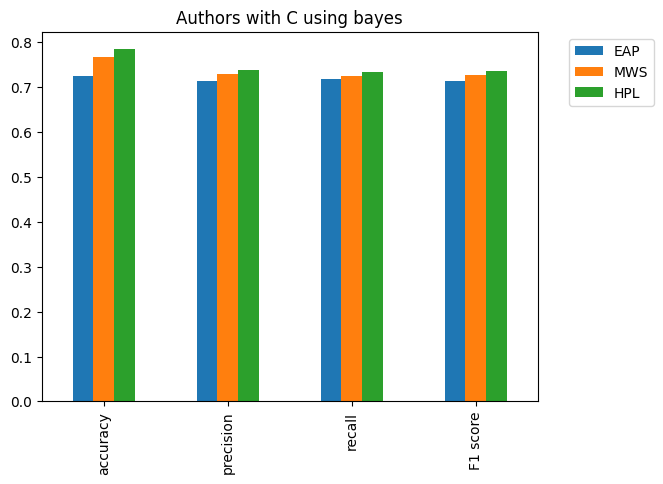

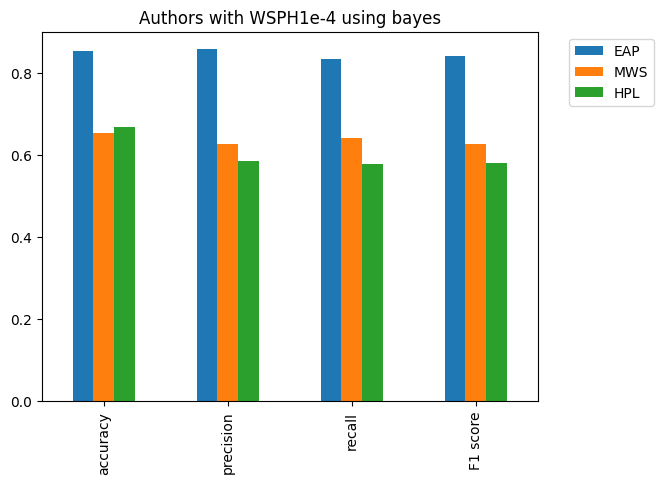

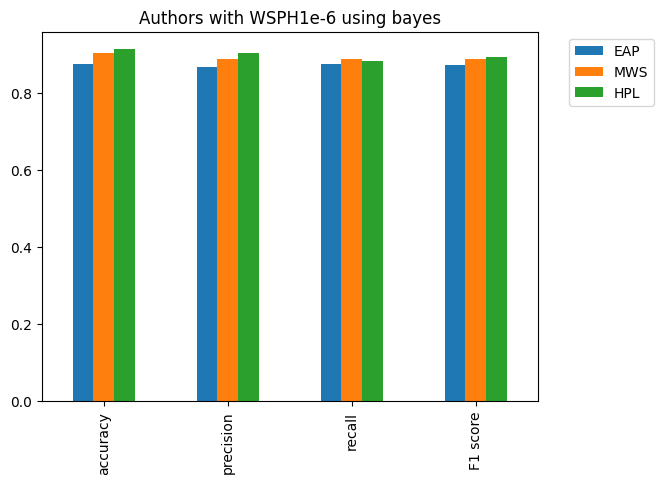

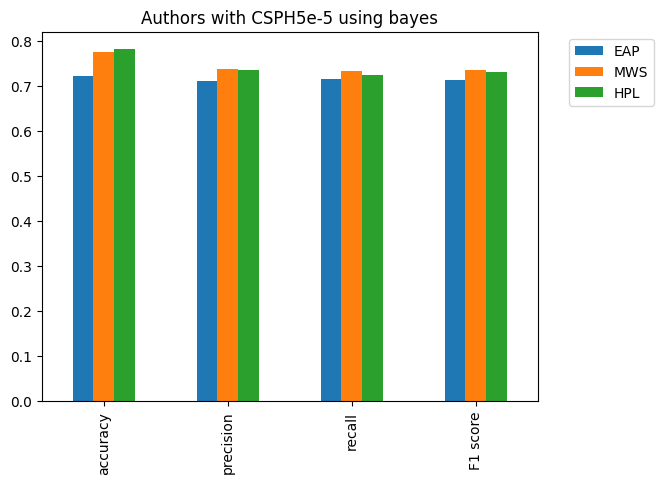

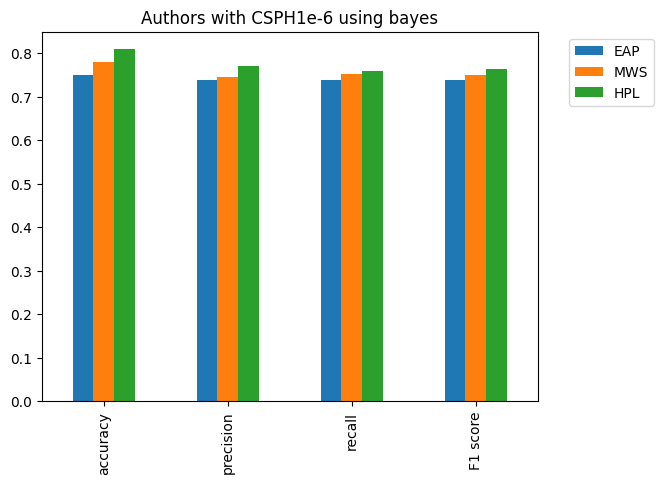

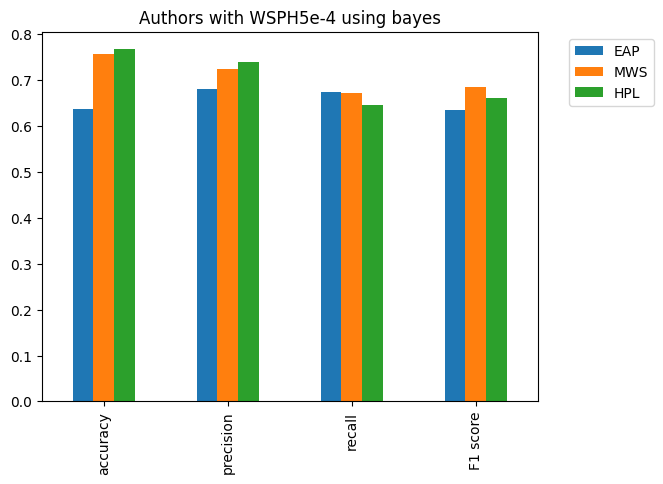

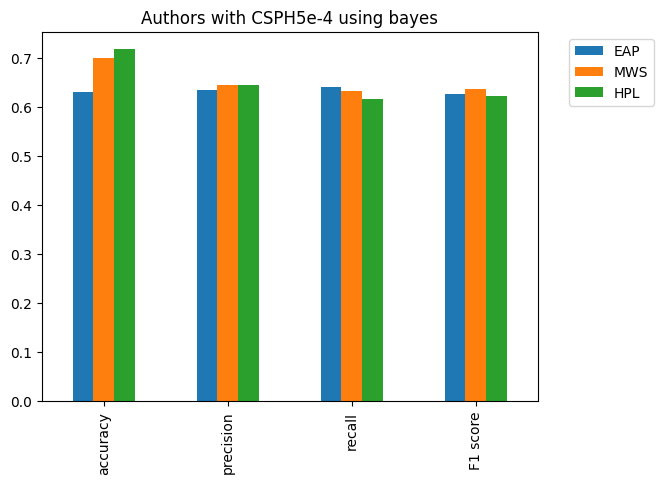

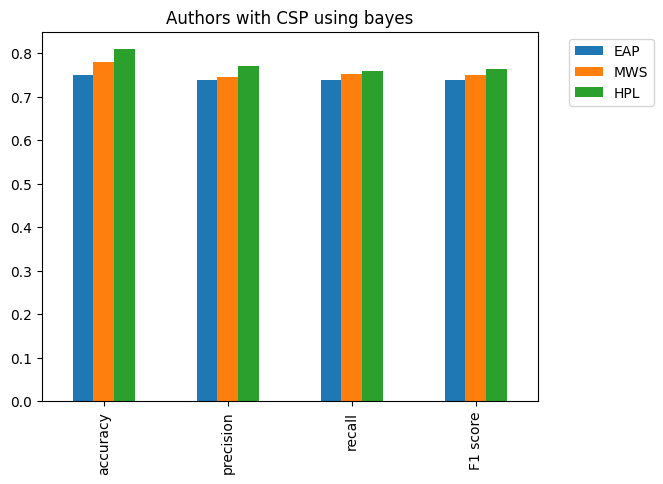

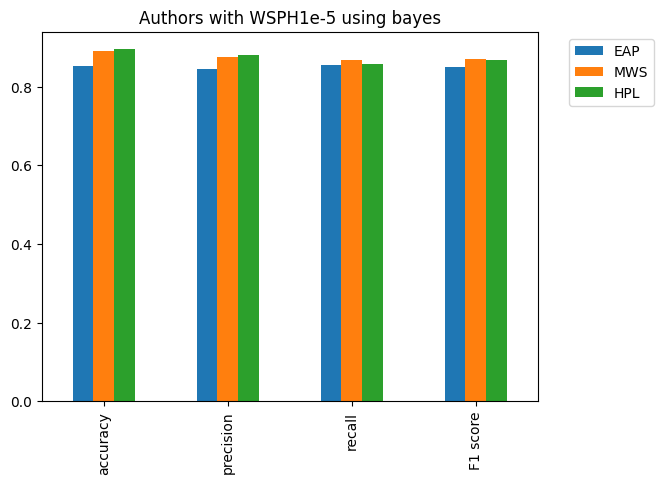

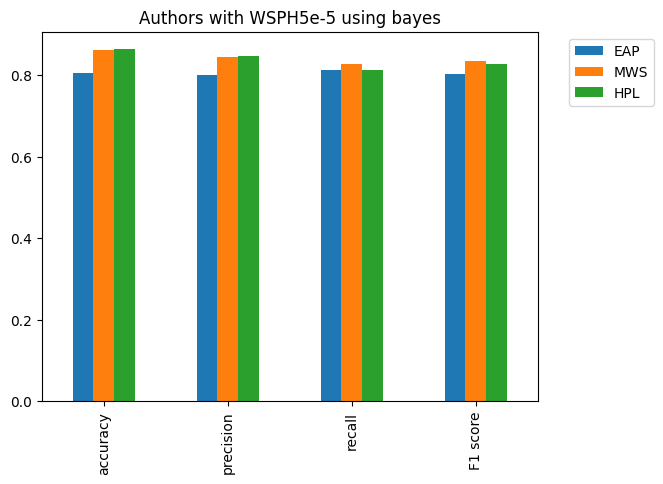

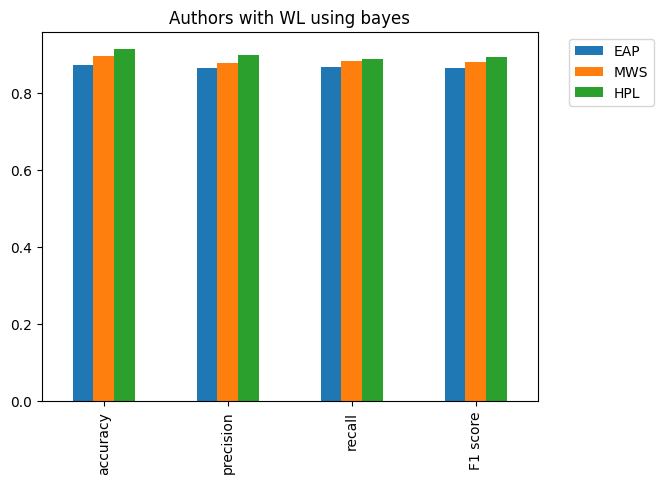

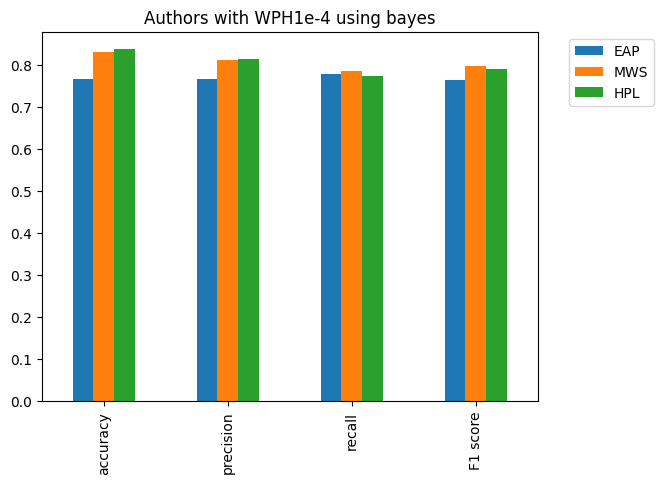

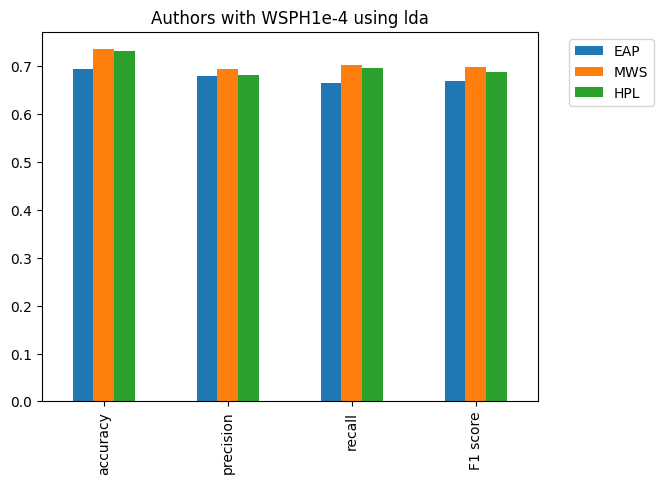

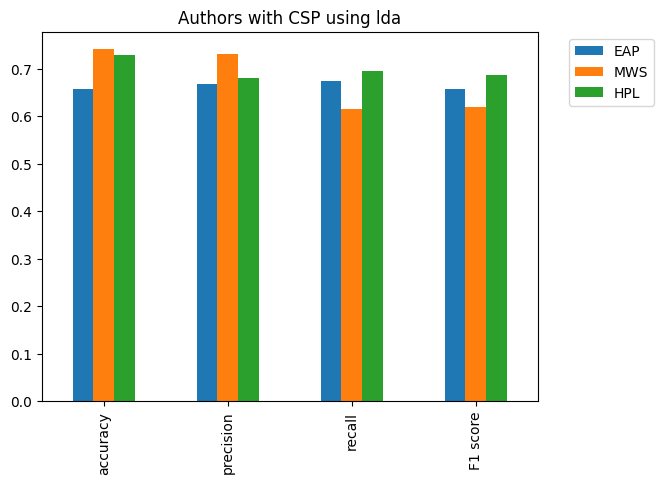

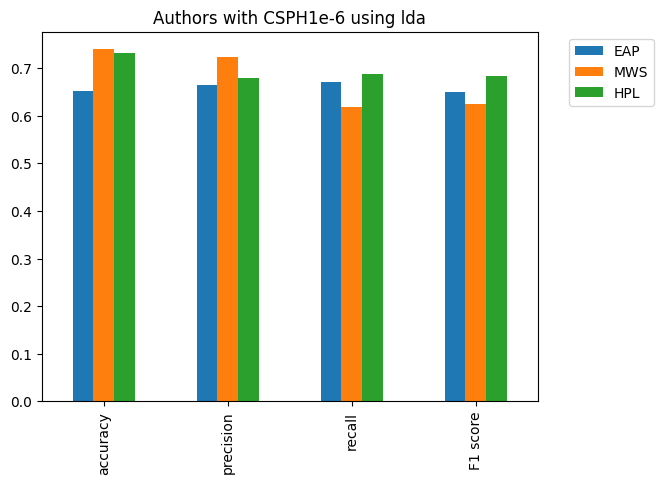

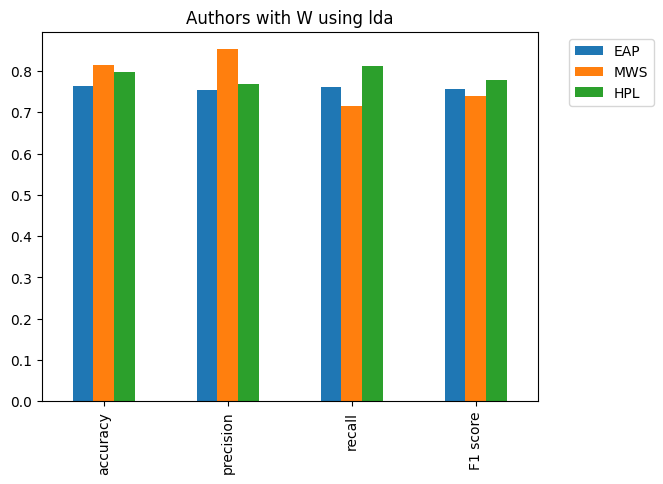

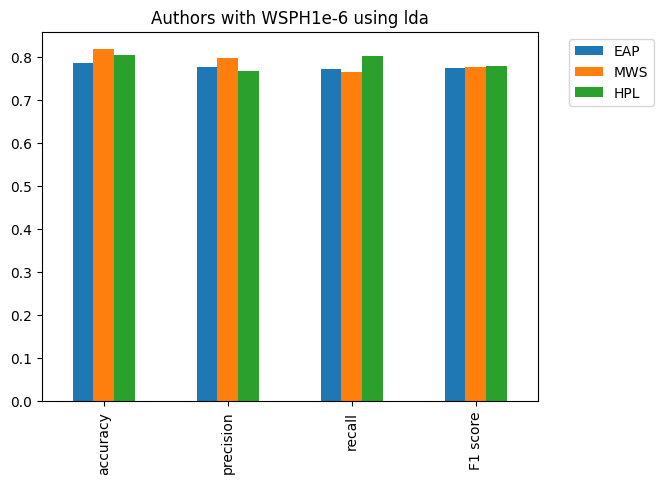

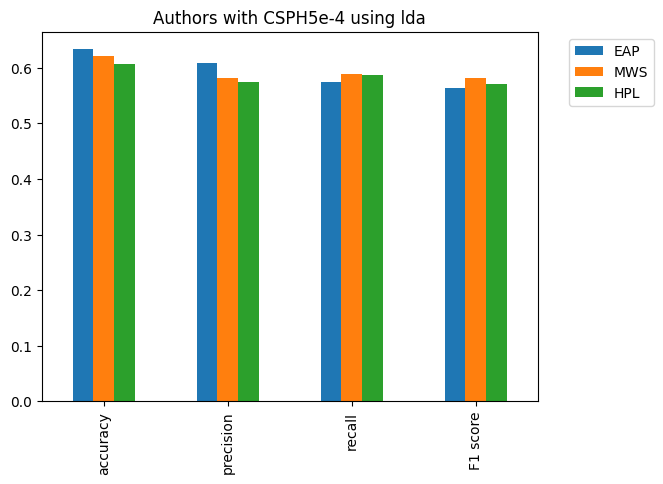

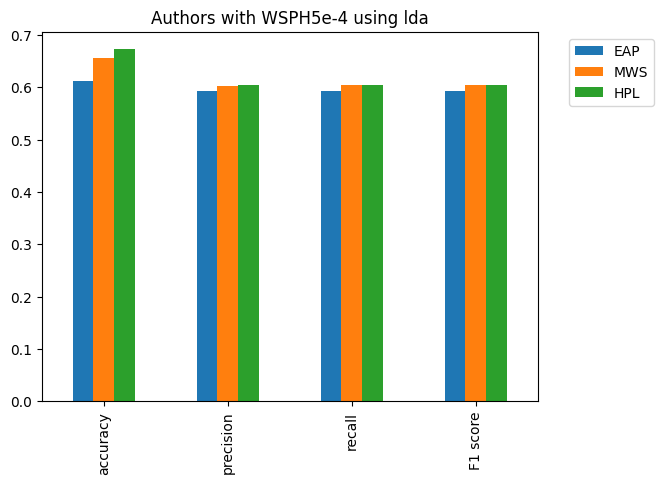

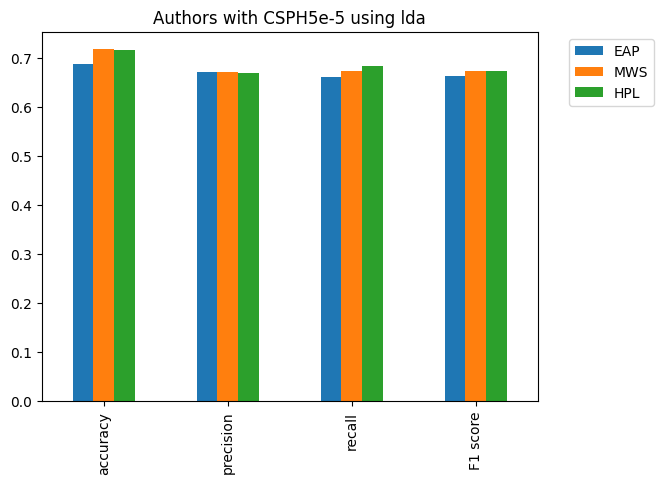

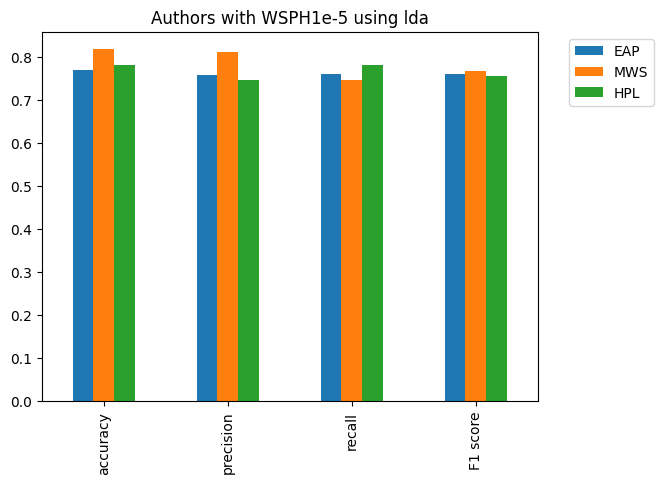

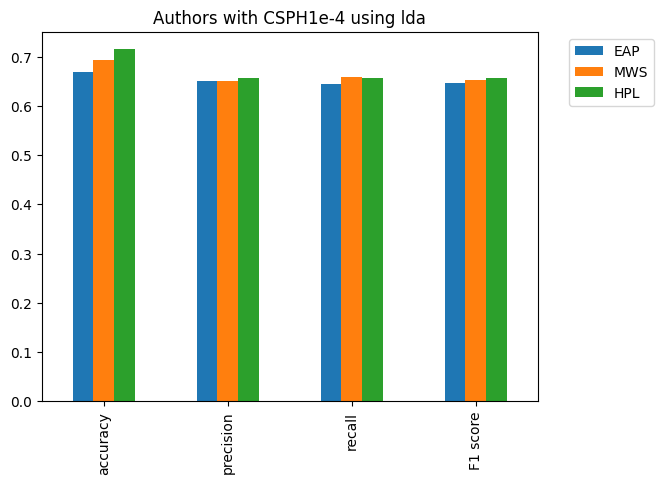

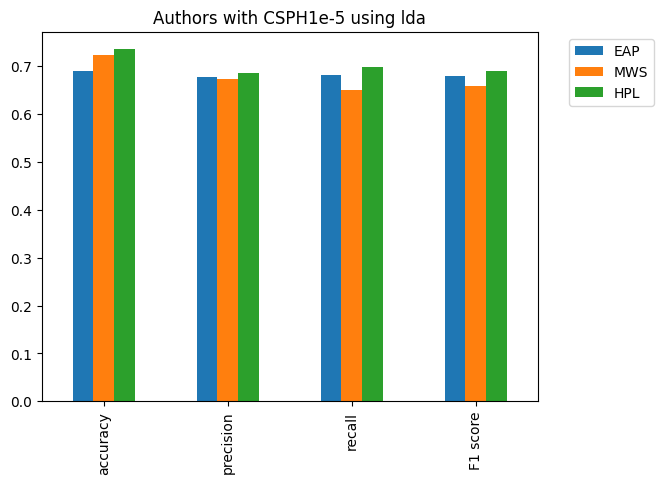

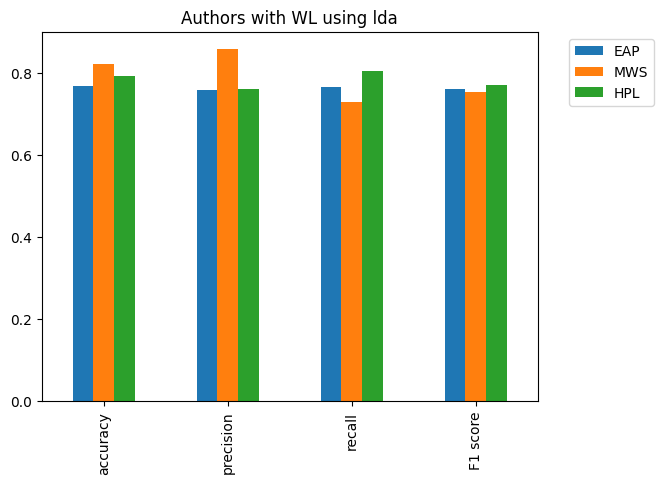

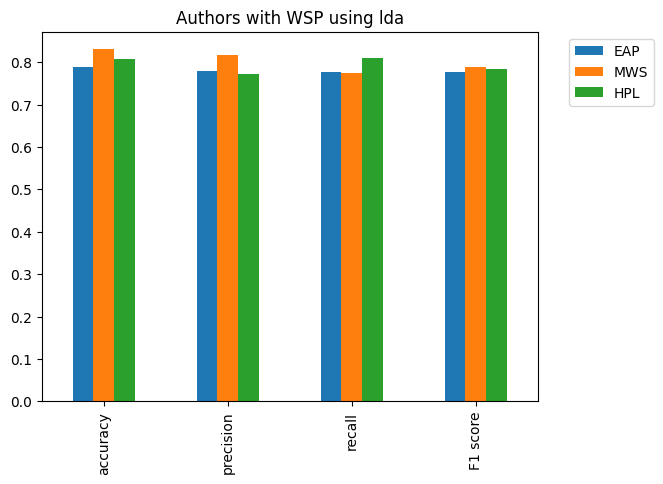

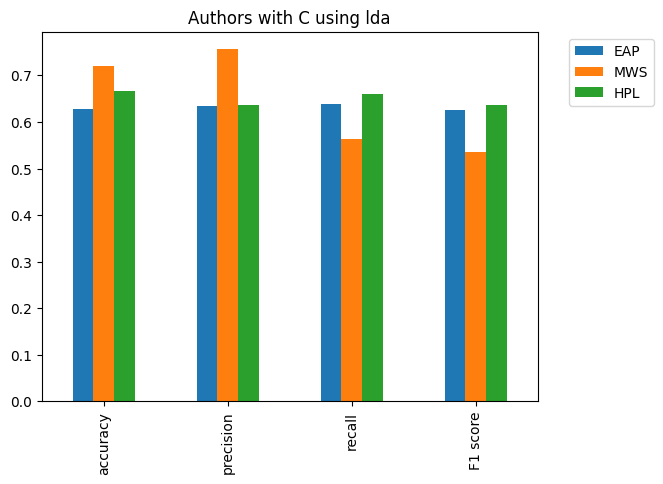

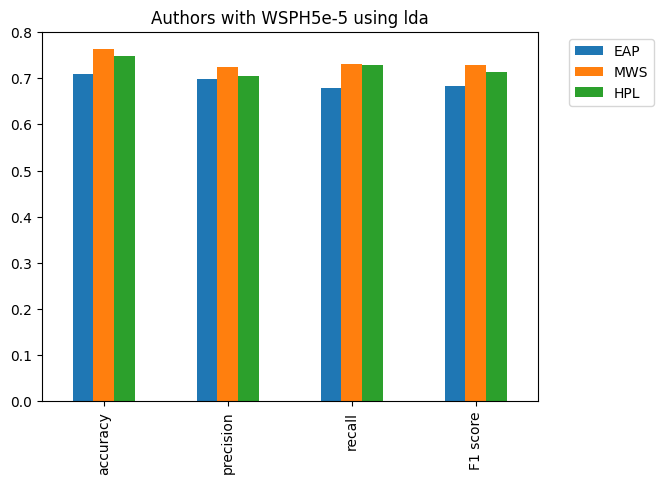

In [8]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(author|{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        score_df = {}
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = [func(author_df["author_short"],author_df.iloc[:, preprocessing]) for (name, func) in metrics]
        score_df = pd.DataFrame(score_df)
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df.plot.bar(title=f"Authors with {preprocess_name} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        

In [9]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})")]
    for preprocessing in range(2,int((len(method_df.columns)))):
        preprocess_name = re.sub(r".*\s(\S+)$", r"\1", method_df.columns[preprocessing])
        display(method_df.groupby(["author_short", method_df.columns[preprocessing]]).size().unstack(fill_value=0))

bayes with W,EAP,HPL,MWS
author_short,,,
EAP,1295,88,160
HPL,127,952,66
MWS,123,56,1049


bayes with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1068,219,256
HPL,321,630,194
MWS,332,172,724


bayes with WSP,EAP,HPL,MWS
author_short,,,
EAP,1349,74,120
HPL,150,931,64
MWS,138,48,1042


bayes with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1063,209,271
HPL,243,733,169
MWS,270,149,809


bayes with C,EAP,HPL,MWS
author_short,,,
EAP,1048,243,252
HPL,261,700,184
MWS,321,158,749


bayes with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1143,167,233
HPL,92,411,642
MWS,80,397,751


bayes with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1349,74,120
HPL,150,931,64
MWS,138,48,1042


bayes with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1067,234,242
HPL,296,677,172
MWS,314,152,762


bayes with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1053,203,287
HPL,230,736,179
MWS,257,137,834


bayes with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1316,83,144
HPL,608,406,131
MWS,588,89,551


bayes with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,1068,201,274
HPL,490,425,230
MWS,485,186,557


bayes with CSP,EAP,HPL,MWS
author_short,,,
EAP,1053,203,287
HPL,230,736,179
MWS,257,137,834


bayes with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1336,87,120
HPL,192,884,69
MWS,175,64,989


bayes with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,1305,105,133
HPL,272,788,85
MWS,249,75,904


bayes with WL,EAP,HPL,MWS
author_short,,,
EAP,1295,88,160
HPL,127,952,66
MWS,123,56,1049


bayes with WPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,1278,114,151
HPL,332,712,101
MWS,316,95,817


lda with WSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,814,374,355
HPL,233,705,207
MWS,236,239,753


lda with CSP,EAP,HPL,MWS
author_short,,,
EAP,1163,297,83
HPL,394,699,52
MWS,566,316,346


lda with CSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1167,290,86
HPL,407,669,69
MWS,582,284,362


lda with W,EAP,HPL,MWS
author_short,,,
EAP,1167,328,48
HPL,168,969,8
MWS,386,288,554


lda with WSPH1e-6,EAP,HPL,MWS
author_short,,,
EAP,1085,284,174
HPL,159,910,76
MWS,218,242,768


lda with CSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,458,563,522
HPL,186,617,342
MWS,166,450,612


lda with WSPH5e-4,EAP,HPL,MWS
author_short,,,
EAP,771,355,417
HPL,373,501,271
MWS,374,283,571


lda with CSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,823,367,353
HPL,246,695,204
MWS,256,291,681


lda with WSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,1102,326,115
HPL,196,895,54
MWS,263,281,684


lda with CSPH1e-4,EAP,HPL,MWS
author_short,,,
EAP,825,320,398
HPL,288,591,266
MWS,293,243,692


lda with CSPH1e-5,EAP,HPL,MWS
author_short,,,
EAP,986,307,250
HPL,277,695,173
MWS,382,282,564


lda with WL,EAP,HPL,MWS
author_short,,,
EAP,1162,339,42
HPL,174,956,15
MWS,354,287,587


lda with WSP,EAP,HPL,MWS
author_short,,,
EAP,1101,303,139
HPL,154,931,60
MWS,228,237,763


lda with C,EAP,HPL,MWS
author_short,,,
EAP,1077,440,26
HPL,393,733,19
MWS,602,450,176


lda with WSPH5e-5,EAP,HPL,MWS
author_short,,,
EAP,815,403,325
HPL,194,781,170
MWS,213,222,793


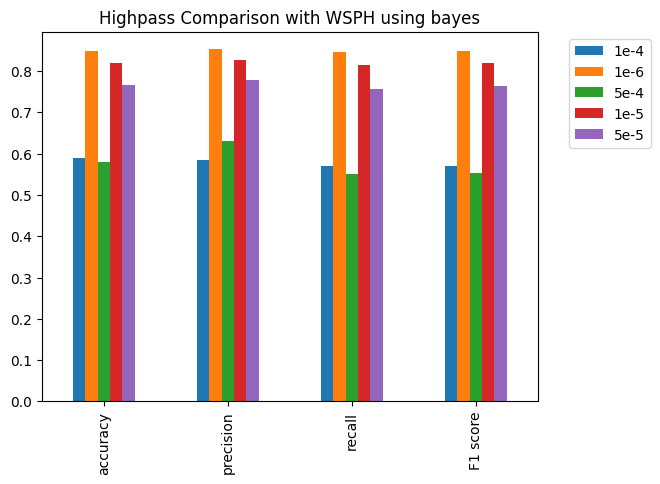

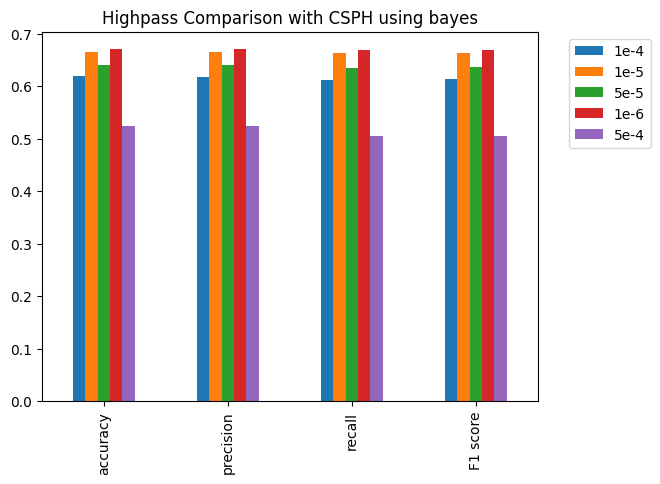

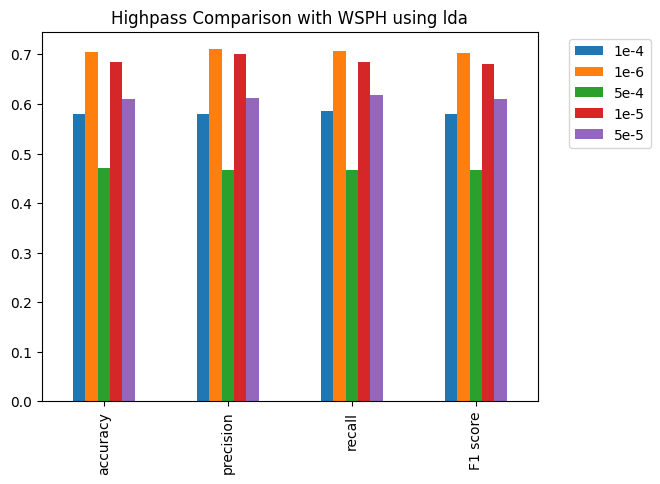

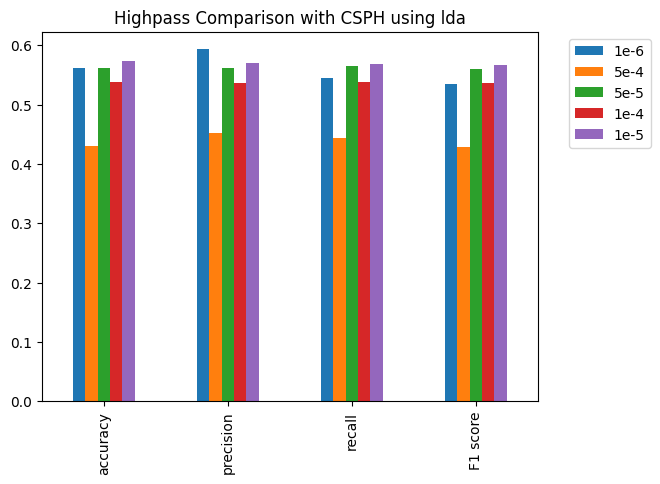

In [10]:
for method in ["bayes", "lda"]:
    for preprocessing in ["WSPH", "CSPH"]:
        method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
        method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
        score_df.index = ["accuracy", "precision", "recall", "F1 score"]
        score_df = score_df.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
        score_df.plot.bar(title=f"Highpass Comparison with {preprocessing} using {method}")
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

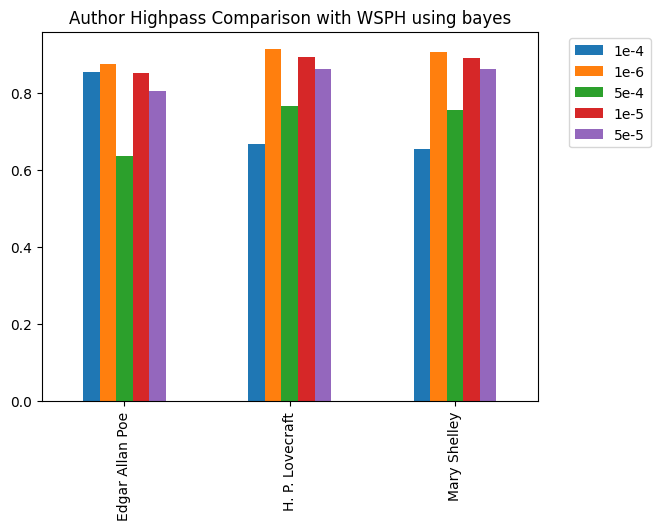

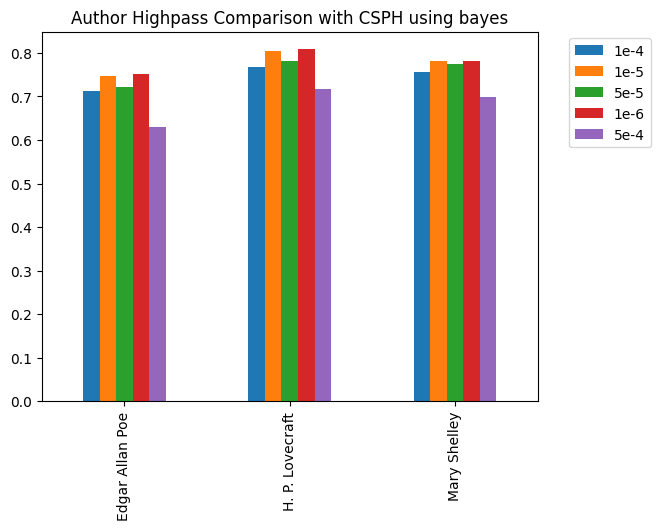

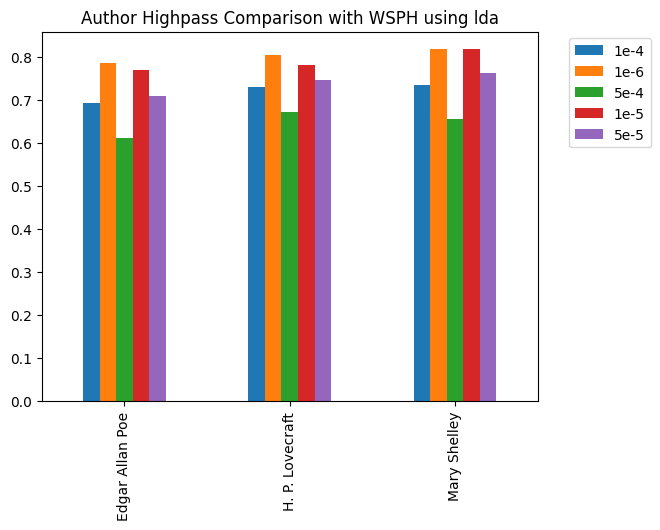

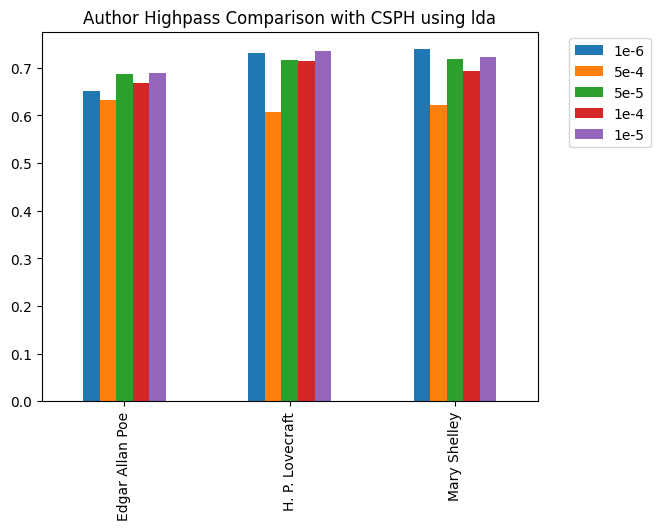

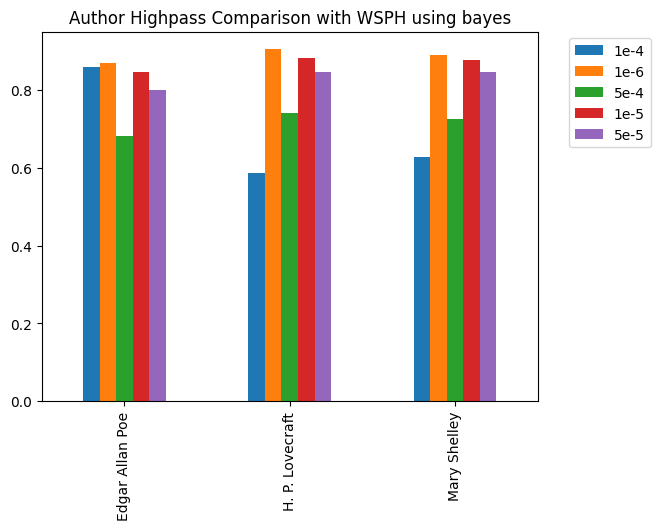

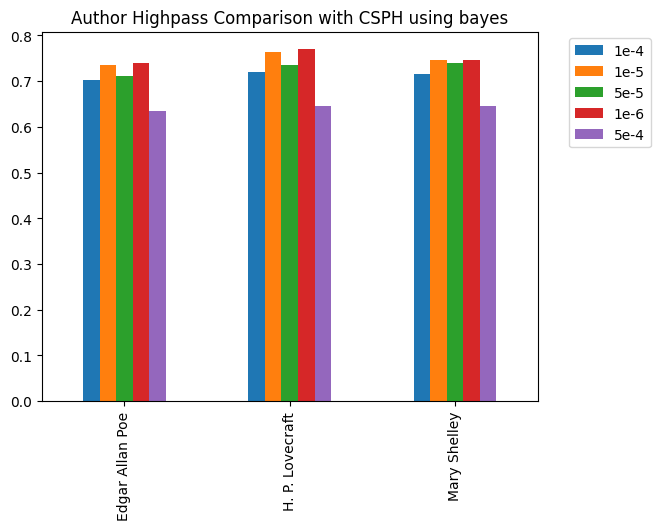

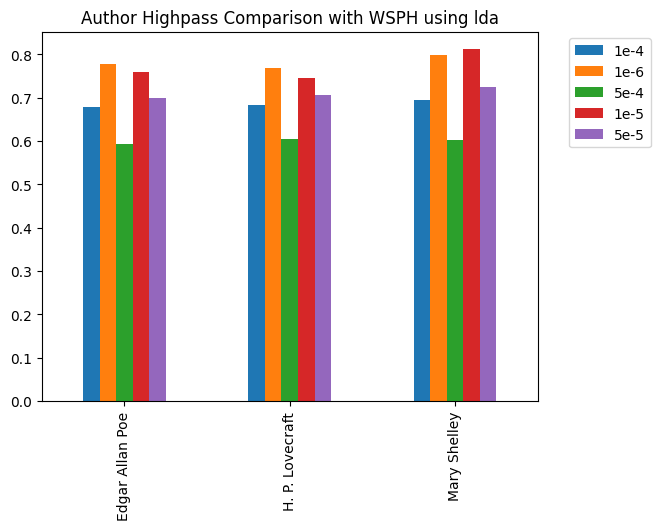

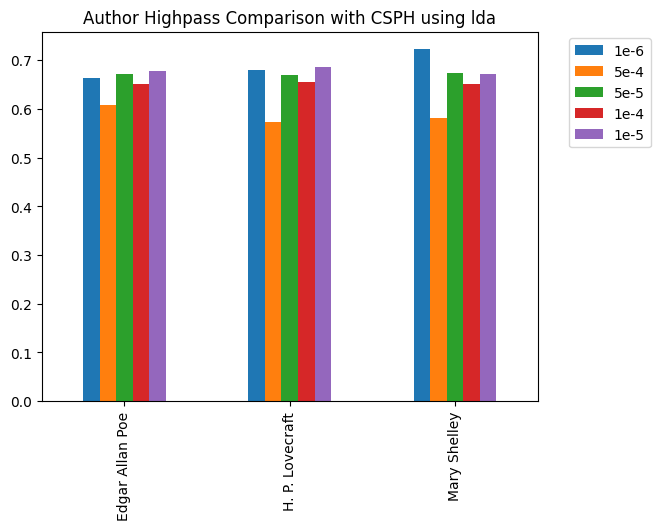

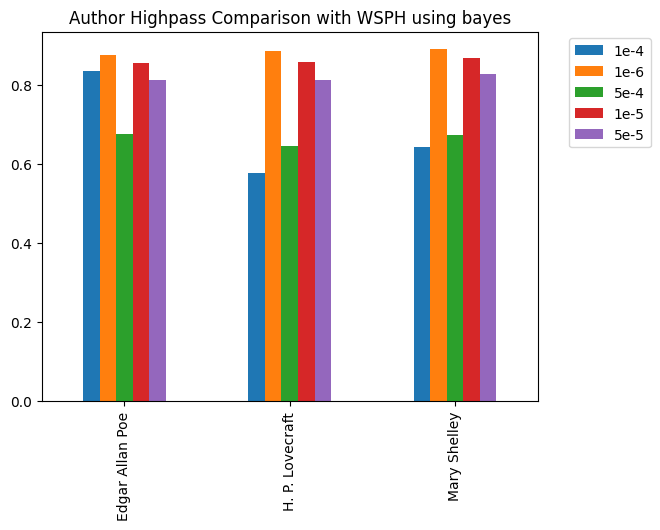

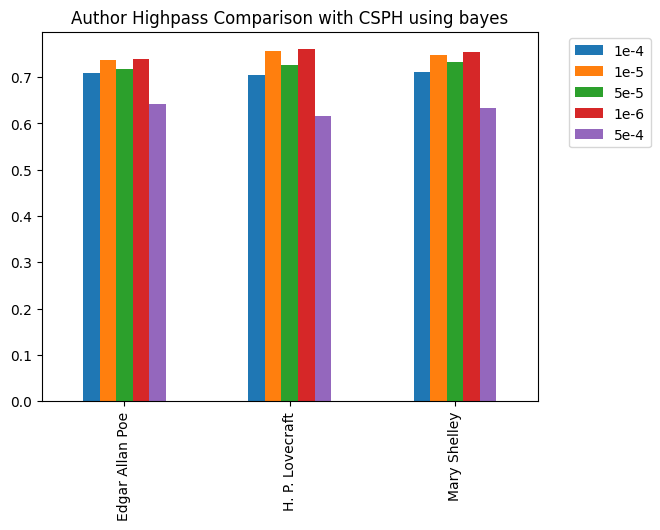

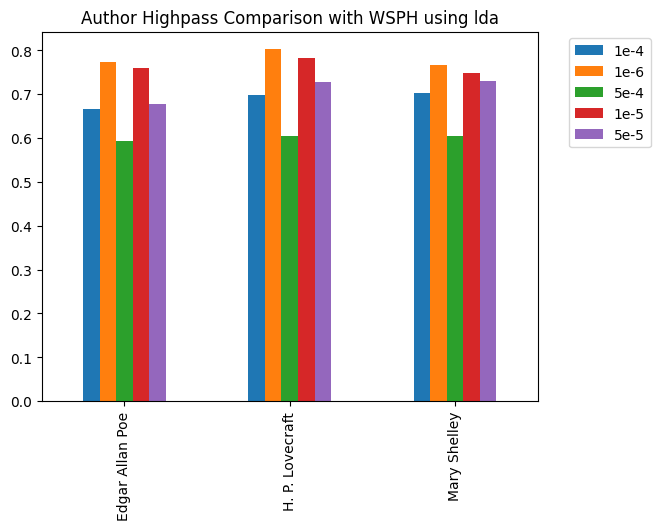

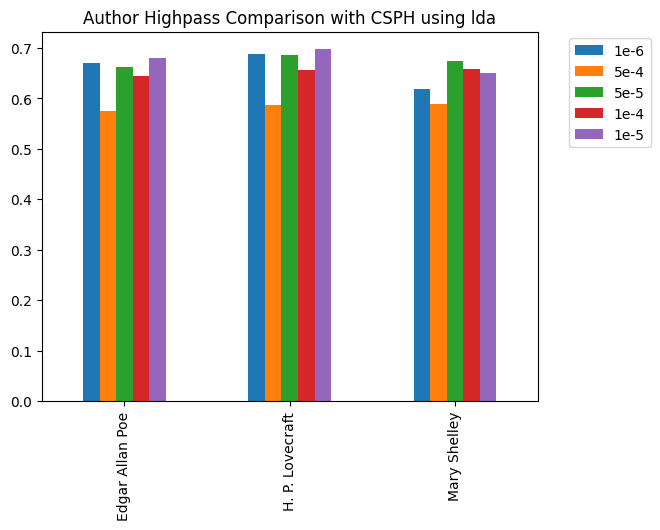

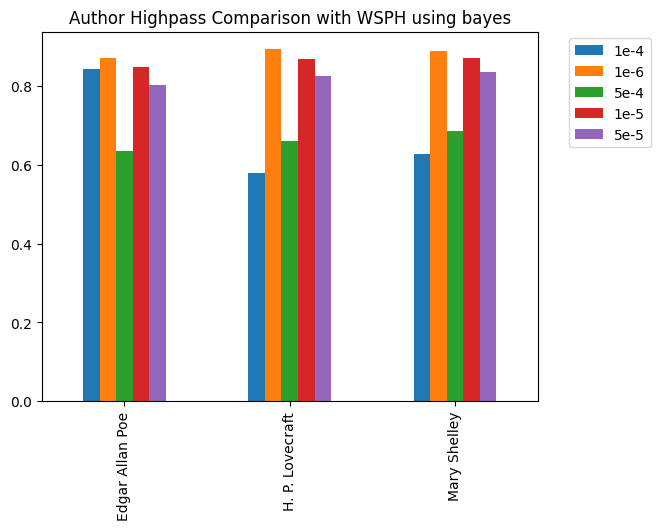

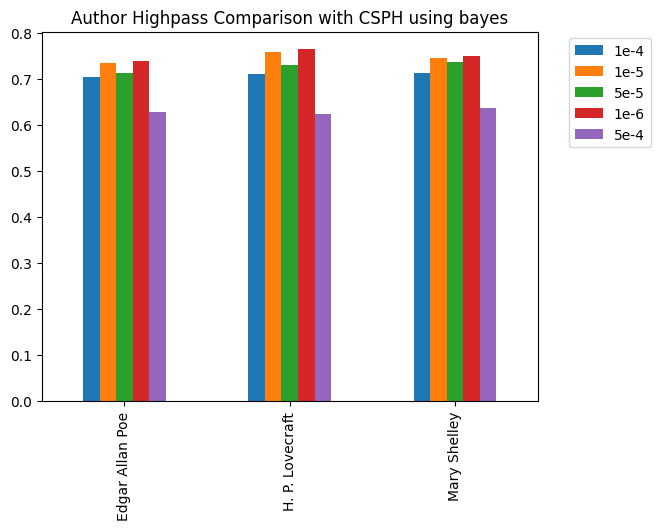

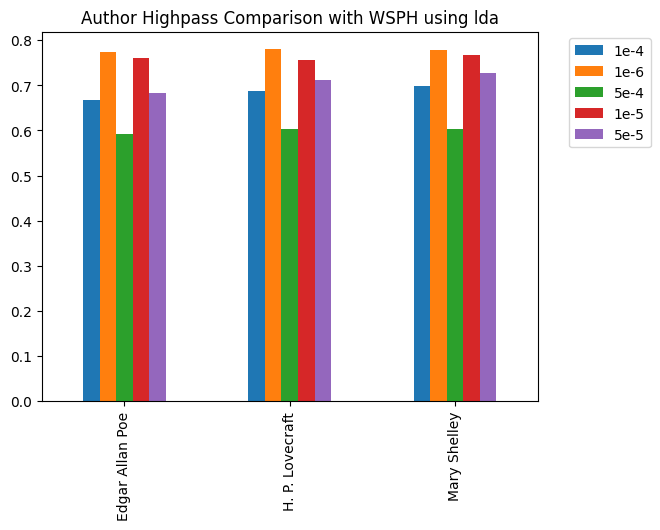

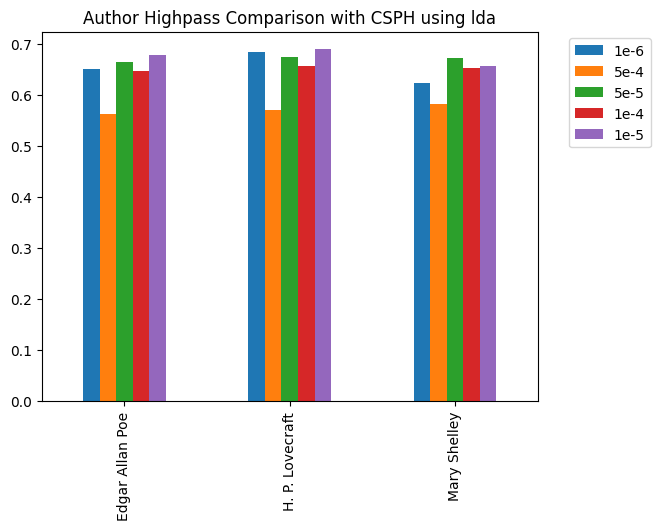

In [11]:
for (name, func) in metrics:
    for method in ["bayes", "lda"]:
        for preprocessing in ["WSPH", "CSPH"]:
            method_df = df.loc[:, df.columns.str.contains(f"(?=.*author)|(?=.*{method})(?=.*{preprocessing})")]
            cutoffs = defaultdict(lambda: [])
            for author in ["EAP", "HPL", "MWS"]:
                author_df = pd.DataFrame(
                    {"author": method_df["author"]})
                author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                    lambda x: [1 if author == i else 0 for i in x])], axis=1)
                for cutoff in range(2,int(len(author_df.columns))):
                    cutoffs[author_df.columns[cutoff]].append(func(author_df["author_short"], author_df.iloc[:, cutoff]))
            cutoffs = pd.DataFrame(cutoffs)
            cutoffs.index = [authors_short_dict[author] for author in ["EAP", "HPL", "MWS"]]
            cutoffs = cutoffs.rename(columns=lambda x: re.sub(r'^\D*(\d.*)', r'\1', x))
            cutoffs.plot.bar(title=f"Author Highpass Comparison with {preprocessing} using {method}")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
